# Expanding NutriScore : take your menu to the next level

### Abstract
Nutrition is a major issue in the Western civilization. The bad eating habits are becoming one of the main causes of illness in the world, with very heavy impact on public health. Recently, the various products are being graded through nutrition benefits indices, as for example NutriScore. 
NutriScore can give an accurate estimation on how healthy an ingredient can be. However, if it can make sense at the ingredient scale, the concept of NutriScore would be way more valuable if it were computed considering wider time spans instead of individual ingredients. Indeed, in its present version, NutriScore would always give a very high grade to white rice, for example. However, if you only eat white rice, your overall nutrition will not be optimal. The present computation of NutriScore is strongly limited, as it is unable to contextualize the consumption of a certain product in regard with the daily feeding practises.

### Imports

In [1]:
# Global imports
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns
import re
from random import randint
sns.set_context('notebook')

# Local imports
from computeNutriScore import computeNutriScore
%run Data_scrapping_USagriculture.ipynb
import df_nutri_create as nutri
from Rec_nutri import Rec_text
from email_nutri import Send_rec
from product_better import find_healthier_product
from product_better import Better_product_rec
from Algo_main import algo

# Warning handling
import warnings
warnings.filterwarnings('ignore')

# Data path
DATA_FOLDER = './data/'

### Milestone 2
Milestone 2 included various tasks, including exploration of the database and 
* First of all, the database was cleaned. The OpenFoodFacts database is a participative database and users can do mistakes, which should be corrected when possible.
* After that, the database was filled using a `similar product` function, which relies on the tags to extrapolate credible predictions to complete missing data.
* After the filling, we are able to visualize the cleaned data.
* Finally, the NutriScore algorithm computes the NutriScore of each product. The algorithm relies on official sources from this <a href= "http://agriculture.gouv.fr/telecharger/87510?token=537276c9f22122955add7292abbcce0d"> document from the Ministry of Agriculture of France [in French].</a>

## OpenFoodFacts Dataset Exploration

In this Milestone 2 , we did not use all the columns that are contained in the OpenFoodFacts database. We rather focus on the latter information :
* `code` : Barcode of the product
* `product_name` : Name of the product 
* `categories_tags` : Tags that describe the product into categories
* `energy_100g` : Amount of energy in the product [kJ] per 100g/100ml
* `fat_100g` : Amount of fats in the product [g] per 100g/100ml
* `saturated-fat_100g` : Amount of subacategories of fats (saturated-fat) in the product [g] per 100g/100ml
* `sugars_100g` : Amount of sugars in the product [g] per 100g/100ml
* `salt_100g` : Amount of salt in the product [g] per 100g/100ml
* `sodium_100g` : Amount of subcategories of salt (sodium) in the product [g] per 100g/100ml
* `fruits-vegetables-nuts_100g` : Ratio of Fruits/Vegetables/Nuts really inside the product [%] per 100g/100ml
* `fruits-vegetables-nuts-estimate_100g` : Ratio of Fruits/Vegetables/Nuts estimated inside the product [%] per 100g/100ml
* `fiber_100g` : Amount of fiber in the product [g] per 100g/100ml
* `proteins_100g` : Amount of protein in the product [g] per 100g/100ml
* `nutrition_grade_fr` : Grade of the product (provided by OpenFoodFacts)
* `nutrition-score-fr_100g` : Score of the product (provided by OpenFoodFacts)

### Loading & Cleaning

We used <a href = "https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv">the database provided by OpenFoodFacts</a> (24.11.2018). 

In [2]:
# Load Data and Clean
data_raw = pd.read_csv(DATA_FOLDER + 'en.openfoodfacts.org.products.csv',
                       delimiter = '\t', low_memory = False)
data_clean = data_raw.copy()

# Drop duplicates according to the code
data_clean.drop_duplicates(subset = 'code', keep = False, inplace = True)
data_clean.set_index('code', inplace = True)

# Drop product without product name and without tags, which are totally unidentifiable
data_clean = data_clean[~data_clean.product_name.isna() & ~data_clean.categories_tags.isna()]

First of all, we deleted the duplicates according to the barcode of the products. Indeed, it is logical that two unique products do not have the same barcode. We didn't keep any duplicate because we couldn't determine which one is the more correct and up-to-date entry. All of our algorithms are using `categories_tags` to categorize a product, so we also removed all the product where the user gave no tags. OpenFoodFacts provided several variants of `categories_tags` (`categories`, `categories_tags`, `categories_fr`) but we decided to keep the one called `categories_tags`, as it seemed to be more complete.

In [3]:
# Create 2 DataFrame - one for only food (useful for compute NutriScore) and an other one with the left columns
column_for_data_food = ['product_name','categories_tags','energy_100g','fat_100g',
                        'saturated-fat_100g','sugars_100g','salt_100g','sodium_100g',
                        'fruits-vegetables-nuts_100g','fruits-vegetables-nuts-estimate_100g',
                        'fiber_100g','proteins_100g']

data_food = data_clean[column_for_data_food]

data_clean.drop(column_for_data_food, axis = 1, inplace = True)

A more condensed dataframe (`data_food`) will be used, as we do not need the other data yet.

In [4]:
data_food.head()

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
0000000001281,Tarte noix de coco,"en:pies,en:sweet-pies,en:coconut-pies",1594.0,22.0,15.5,21.9,0.100,0.039370,NaN,NaN,4.4,4.6
0000000001885,Compote de poire,"en:plant-based-foods-and-beverages,en:plant-ba...",657.0,0.0,0.0,27.0,0.000,0.000000,NaN,NaN,3.6,0.6
0000000005470,BAguette bressan,"en:plant-based-foods-and-beverages,en:plant-ba...",669.0,2.2,0.5,0.6,0.358,0.140945,NaN,NaN,1.6,9.5
0000000005661,Pavé de saumon fumé à la ficelle,"en:seafood,en:fishes,en:salmons,en:smoked-fish...",1059.0,17.0,2.6,0.5,2.500,0.984252,NaN,NaN,NaN,23.0
0000000020114,Naturablue original,en:dietary-supplements,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0


In [5]:
data_food.describe(percentiles = [.25, .50, .75, .99])

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
count,8.804500e+04,87268.000000,86498.000000,86903.000000,85960.000000,85959.000000,2037.000000,4962.000000,4.703200e+04,87815.000000
mean,1.229876e+03,14.225595,5.617725,16.884051,3.100454,1.220786,43.809893,43.663653,1.184326e+05,7.610223
std,1.646203e+04,226.545393,43.286334,415.153871,187.044608,73.642392,33.050873,29.174084,2.568375e+07,26.436144
min,0.000000e+00,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,0.000000,-5.000000e+00,-5.560000
25%,3.850000e+02,0.600000,0.120000,0.900000,0.050000,0.019685,12.000000,14.000000,0.000000e+00,1.000000
50%,9.790000e+02,6.000000,1.700000,3.900000,0.500000,0.196850,44.000000,50.000000,1.500000e+00,5.500000
75%,1.594000e+03,21.000000,7.200000,17.000000,1.200000,0.472441,65.000000,62.000000,3.200000e+00,10.200000
99%,3.684680e+03,92.000000,50.000000,82.000000,10.300000,4.055118,100.000000,100.000000,1.750000e+01,29.700000
max,2.790000e+06,66700.000000,10000.000000,86700.000000,50800.000000,20000.000000,100.000000,100.000000,5.570000e+09,4400.000000


One can see that `sugars_100g`, `fiber_100g` and `proteins_100g` have incoherent values (negative values). One can observe that some products take a huge energy value, so we decide to put a limit at 4'000 kJ for 100g/100ml, which corresponds to the $mean + alpha*std$, where mean is the mean of `energy_100g` and alpha = 0.17. These outliers are set to NaN. The other columns of food have also erroneous values. Other incoherent values, as values exceeding 100g per 100g of product were also set to NaN.

In [6]:
def Complete_ratio_column(df):
    '''Give an idea of the filling of the columns of a given dataset'''
    for column in df.columns:
        ratio = len(df[[column]].dropna()) * 100/len(df)
        print("For {}, {} % is complete".format(column, round(ratio, 3)))
        
Complete_ratio_column(data_food)

For product_name, 100.0 % is complete
For categories_tags, 100.0 % is complete
For energy_100g, 87.462 % is complete
For fat_100g, 86.691 % is complete
For saturated-fat_100g, 85.926 % is complete
For sugars_100g, 86.328 % is complete
For salt_100g, 85.391 % is complete
For sodium_100g, 85.39 % is complete
For fruits-vegetables-nuts_100g, 2.024 % is complete
For fruits-vegetables-nuts-estimate_100g, 4.929 % is complete
For fiber_100g, 46.721 % is complete
For proteins_100g, 87.234 % is complete


One should notice that some columns are more complete than others. The low fruits/vegetables/nuts ratio is low as it is rarely provided in the list of ingredients (sadly not legally mandatory) and users also it's not easy for users to estimate this ratio. The fiber content is also low compared to the others but one can think that this could be due to the beverages which never contain this information. 

In [7]:
def Compute_energy(fat, sugar, prot, fiber, margin):
    ''' Computes energy with a margin in kJ. source : https://en.wikipedia.org/wiki/Food_energy '''

    energy = (37 * fat + 17 * (sugar + prot) + 8 * fiber) - margin
    if energy < 0:
        return 0
    return energy

The dataset is full of incoherencies. Some values exceed 100g of nutrients for 100g of food. Some others are negative. Sometimes salt and sodium are not perfectly correlated when they should be (salt is made up of NaCl). Sometimes the energy also exceeds 4000kJ per 100g, which is highly unlikely, except in specific cas, which will be corrected in the last loop. To clean our database, we check if the values (if provided) is inside a coherent range. As will see it later, for some products, the amount of saturated fat exceeds the total amount of fat. This will be considered as incoherent value. Sometimes salt and sodium are not perfectly correlated when they should be. Indeed the Salt-Sodium ratio is 2.5 so we also check this relation and we can also complete the dataset, in the case where either salt or sodium is missing. We also check if the estimated content fruits/vegetables/nuts is more than the real one and we can fill the estimated one if it is missing by the real one, in order to facilitate later completion. We also compute a theoretical energy value with a margin of 150kJ, based on the <a href= "https://en.wikipedia.org/wiki/Food_energy#Nutrition_labels">energy density of nutrients.</a> The products cannot have less energy than this baseline value. 

In [8]:
def set_coherent_values(df):
    """ Compute coherent value for food values. Set incoherent values to NaN or assign a valid value. """
    for i in range(len(df)):
        
        # energy
        value = df.iat[i, 2]
        if  value < 0 or value > 4000:
            df.iat[i, 2] = np.nan
        
        # other columns
        for column in range(3, len(df.columns)):
            value = df.iat[i, column]
            if (value < 0) or (value > 100):
                df.iat[i, column] = np.nan
                
        # Salt / Sodium (should be perfectly correlated)        
        if np.isnan(df.iat[i, 6]):
            if ~np.isnan(df.iat[i, 7]):
                if ((df.iat[i, 7] * 2.5) <= 100):
                    df.iat[i, 6] = df.iat[i, 7] * 2.5 # Salt = Sodium * 2.5
                else:
                    df.iat[i, 7] = np.nan # Sodium must be a error value
        else:
            if np.isnan(df.iat[i, 7]):
                if ((df.iat[i, 6] / 2.5) <= 100):
                    df.iat[i, 7] = df.iat[i, 6] / 2.5 # Sodium = Salt / 2.5
                else:
                    df.iat[i, 6] = np.nan # Salt must be a error value
        
        # Saturated Fat / Fats                   
        if df.iat[i, 4] > df.iat[i, 3]: #saturated fat > fat
            df.iat[i, 3] = df.iat[i, 4]
        
        # Fruit-Vegetables-Nut Real / Estimate
        if ~np.isnan(df.iat[i, 8]) & np.isnan(df.iat[i, 9]):
            df.iat[i, 9] = df.iat[i, 8] # Estimate fruits-vegetables-nuts = Real
        if ~np.isnan(df.iat[i, 8]) & (df.iat[i, 9] > df.iat[i, 8]):
            df.iat[i, 9] = df.iat[i, 8]
        
        # Energy
        Fat, Sugar, Prot, Fiber = 0,0,0, 0
        if ~np.isnan(df.iat[i, 3]):
            Fat = df.iat[i, 3]
                
        if ~np.isnan(df.iat[i, 5]):
            Sugar = df.iat[i, 5]
                
        if ~np.isnan(df.iat[i, 11]):
            Prot = df.iat[i, 11]
            
        if ~np.isnan(df.iat[i, 10]):
            Fiber = df.iat[i, 10]
        
        energy_comput = Compute_energy(Fat, Sugar, Prot, Fiber, 150)
        
        if np.isnan(df.iat[i, 2]) | (df.iat[i, 2] < energy_comput):
            df.iat[i, 2] = energy_comput       
            
    return df

data_food = set_coherent_values(data_food)

In [9]:
data_food.describe()

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
count,100666.000000,87247.000000,86484.000000,86867.000000,85868.000000,85868.000000,2037.000000,6972.000000,47015.000000,87794.000000
mean,942.235779,13.394582,5.341936,13.391711,1.164044,0.458301,43.809893,43.640146,2.521230,7.348125
std,822.762995,18.231097,8.623938,19.619113,4.938022,1.944391,33.050873,30.332024,4.090255,7.829458
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,205.000000,0.600000,0.120000,0.900000,0.050000,0.019685,12.000000,13.775000,0.000000,1.000000
50%,782.000000,6.000000,1.700000,3.900000,0.500000,0.196850,44.000000,49.550000,1.500000,5.500000
75%,1515.000000,21.000000,7.200000,17.000000,1.200000,0.472441,65.000000,63.000000,3.200000,10.200000
max,5250.000000,100.000000,100.000000,100.000000,100.000000,40.000000,100.000000,100.000000,100.000000,100.000000


In [10]:
data_food[data_food.energy_100g > 4000]

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
3250390000532,Bouton D Or Huile Mais,en:fats,5250.0,100.0,NaN,50.0,0.0,0.0,NaN,NaN,0.0,50.0


The resulting cleaning seems to be good and functionnal. Note that the maximum amount of energy is not 4'000 kJ anymore. Indeed this is due to our theoritical energy value correction. It concerns some products that have a huge amount of fats, sugar or proteins.

In [11]:
def list_df_tags(data_food):
    """ List of all the tags found in the dataset. Count the number of occurences and rank them
        according to this number. """
    
    # Split the tags found in the categories_tags columns
    all_tags = [tags.split(',') for tags in list(data_food[['categories_tags']].dropna().categories_tags)]
    
    # Init
    list_tags = []
    
    # List them
    for tags in all_tags:
        for tag in tags:
            if tag != '':
                list_tags.append(tag)
    
    # Return the list by number of occurences 
    return dict(Counter(list_tags).most_common())

In [12]:
dic_tag = list_df_tags(data_food)

In [13]:
def relevant_tag(dic, tags, threshold = 5):
    """ Returns the least frequent tag from the list, who however has more than 'threshold' 
    correspondancies in the database """
    
    # Init
    dict_, sort = {}, []
    
    for tag in tags:
        if tag in dic:
            dict_[tag] = dic[tag]
    
    # Keep only tag which have more occurencies than threshold
    dict_ = {k: v for k, v in dict_.items() if v >= threshold}
    if len(dict_) > 0:
        # Returns the most relevant tags
        sort = sorted(dict_, key = dict_.get, reverse=False)
        return sort
    else :
        return None

At this point, all the products that contains 9 empty columns (meaning that there is only energy indication left) were removed, as this means that they contain absolutely no data at the beginning and would only rely on filling. It really does not make sense to complete a product where all values would have to be completed with predicted ones. One can see that these very flawed products correspond essentially to dietary supplements and honeys.

In [14]:
# Select rows which have to many missing values
data_food_left = data_food[(data_food.isnull().sum(axis = 1) == 9) & 
                           ~(data_food.categories_tags.str.contains('beverages', case = False))]

# Observe the lowest-level relevant tags which are found in these rows
list_tag = []
for index in range(len(data_food_left)):
    sort = relevant_tag(dic_tag, data_food_left.iloc[index].categories_tags.split(','), 1)
    list_tag.append(sort[0])

# Print top-ten lowest-level relevant tags in these rows 
i = 1
for key, value in dict(Counter(list_tag).most_common()).items():
    if i <= 10:
        print('{} products have the tag : {}'.format(value, key))
    i = i + 1

79 products have the tag : en:dietary-supplements
58 products have the tag : en:cheeses
52 products have the tag : en:chicken-breasts
48 products have the tag : fr:miels-d-acacia
48 products have the tag : en:free-range-eggs
44 products have the tag : en:candies
44 products have the tag : en:honeys
43 products have the tag : en:groceries
42 products have the tag : en:biscuits
38 products have the tag : en:mustards


In [15]:
# Remove very incomplete products
data_food = data_food[~(data_food.isnull().sum(axis = 1) >= 9) | 
                      (data_food.categories_tags.str.contains('beverages', case = False))]

# Display completeness of the cleaned dataset
Complete_ratio_column(data_food)

For product_name, 100.0 % is complete
For categories_tags, 100.0 % is complete
For energy_100g, 100.0 % is complete
For fat_100g, 91.885 % is complete
For saturated-fat_100g, 91.082 % is complete
For sugars_100g, 91.485 % is complete
For salt_100g, 90.433 % is complete
For sodium_100g, 90.433 % is complete
For fruits-vegetables-nuts_100g, 2.145 % is complete
For fruits-vegetables-nuts-estimate_100g, 7.343 % is complete
For fiber_100g, 49.514 % is complete
For proteins_100g, 92.461 % is complete


In [16]:
dic_tag = list_df_tags(data_food)

In [17]:
# Select the tags which miss fiber data
data_food_left = data_food[data_food.fiber_100g.isna()]

# Observe the lowest-level relevant tags which are found in these rows
list_tag = []
for index in range(len(data_food_left)):
    sort = relevant_tag(dic_tag, data_food_left.iloc[index].categories_tags.split(','), 1)
    list_tag.append(sort[0])

# Print top-ten lowest-level relevant tags in these rows 
i = 1
for key, value in dict(Counter(list_tag).most_common()).items():
    if i <= 10:
        print('{} products have the tag : {}'.format(value, key))
    i = i + 1

983 products have the tag : en:non-alcoholic-beverages
490 products have the tag : en:sugared-beverages
444 products have the tag : en:fats
348 products have the tag : en:white-hams
313 products have the tag : en:dark-chocolates
257 products have the tag : en:milks
213 products have the tag : en:candies
212 products have the tag : en:squeezed-apple-juices
197 products have the tag : en:biscuits
181 products have the tag : en:gelified-candies


One can remark that the products which do not have fiber data entered are mostly beverages, as expected.

### Filling

We propose three different methods to complete our database :
* `similar_product` : we fill a missing column of a product with a median value of similiar products according to the tags (from the more specific ones, tag with less products, to the more general tags). If the product is not complete after that we take the median of all the database. 

* `API` : We collect via API from US agriculture a similar product according to the name of our product inside their database.

* `User-fill` : The user has to fill itself the missing values.

The tags are branched in a tree. E.g. a product will have the tags <canned-food\><compote\><apple-compote\><apple-compote-with-cinnamon\>. If such a product is missing some data, we will first check if the lowest-level tag ("most relevant tag") has enough complete representatives in the dataset to extrapolate the missing values from these similar products. Otherwise, we go down to the second tag (here <apple-compote\>) and repeat the operation, etc. We do this over the whole dataset, until almost all products could be filled.

In [18]:
def similar_product(product, df, dic_tag):
    ''' When a product miss certain data, we complete it with the most similar products, according to tags. '''
    
    product_fill = product.copy()
    
    # Check if the product need to be filled
    if product_fill.isnull().sum(axis=1)[0] > 0:
        
        # Sort the tags of the product from the less used to the more used in the dataframe
        tags = product.categories_tags[0].split(',')
        tag_sorted = relevant_tag(dic_tag, tags, 3)
        
        if tag_sorted != None:
            
            # Iterate on each tag to complete
            for tag_i in range(len(tag_sorted)):
                tag = tag_sorted[tag_i]
                
                # Take product on the same 'type' as the product we want to fill
                df_for_average = df[df.categories_tags.str.contains(tag, case = False)]
                for j in range(2,len(product_fill.columns)):
                    if j != 8 : # Not complete real fruits/vegetables/nuts
                    
                        # The column need to be filled
                        if str(product_fill.iat[0, j]) == 'nan':
                            df_for_average_ = df_for_average[product_fill.columns[j]].copy()
                            df_for_average_.dropna(axis=0, inplace = True)

                            # The same products have values
                            if len(df_for_average_) > 0:
                                product_fill.iat[0, j] = np.median(df_for_average[product_fill.columns[j]].\
                                                                   dropna(axis=0).tolist())
                            # It's the last tag
                            elif tag_i == (len(tag_sorted) - 1):
                                
                                # If the same product doesn't have values, we take the values of the entire dataframe
                                data_all = df[product_fill.columns[j]].dropna(axis=0).copy()
                                if len(data_all) > 0:
                                    product_fill.iat[0, j] = np.median(data_all.tolist())
                                else:
                                    # Your data frame doesn't have at least one value 
                                    raise NameError('Your entire data_frame do not have values for : {}'.\
                                                    format(product_fill.columns[j]))

                        if product_fill.isnull().sum(axis=1)[0] == 0:
                            break

                if product_fill.isnull().sum(axis=1)[0] == 0:
                        break
        else:
            for j in range(1,len(product_fill.columns)):
                if j != 8: # Not complete real fruits/vegetables/nuts
                    if str(product_fill.iat[0, j]) == 'nan':
                        product_fill.iat[0, j] = np.median(df[product_fill.columns[j]].dropna().tolist())
            
    return product_fill

In [19]:
def fill_from_Api(product):
    ''' This function uses the API from US Agriculture department to scrap information about the product '''
    product_fill = product.copy()
    
    if product_fill.isnull().sum(axis=1)[0] > 0:
        
        # The US database is ASCII-encoded, while our should at least be latin-1
        # Therefore, we handle here the most frequent exceptions
        query = product.product_name[0]
        query = re.sub('[éèêëÈÉÊË]', 'e', query)
        query = re.sub('[àáâãäåæÀÁÂÃÄÅÆ]', 'a', query)
        query = re.sub('[òóôõöøÒÓÔÕÖØ]', 'o', query)
        query = re.sub('[ùúûüÙÚÛÜ]', 'u', query)
        query = re.sub('[ìíîïÌÍÎÏ]', 'i', query)
        query = re.sub('[ýÿÝŸ]', 'y', query)
        query = re.sub('[ñÑ]', 'y', query)
        query = re.sub('[çÇ]', 'c', query)
        query = re.sub('[ß]', 'ss', query)
        query = re.sub('[$£ÞÐð]', '', query)
        
        # Scrap from the US database
        dic = scrap(query_ = query)
        
        # Format the result in the same system than openfoodfacts
        tags = product.categories_tags[0]
        code = product.index[0]
        columns = {
            'Name' : 'product_name',
            'kJ' : 'energy_100g',
            'Proteins': 'proteins_100g',
            'Sugars' : 'sugars_100g',
            'Sat_fats' : 'saturated-fat_100g',
            'Fibers': 'fiber_100g',
            'Sodium': 'sodium_100g',
            'Lipids' : 'fat_100g',
            'Fruit_Veg_content' : 'fruits-vegetables-nuts-estimate_100g'
        }

        column_for_product = ['product_name','categories_tags','energy_100g',
                              'fat_100g','saturated-fat_100g','sugars_100g',
                              'salt_100g','sodium_100g','fruits-vegetables-nuts_100g',
                              'fruits-vegetables-nuts-estimate_100g','fiber_100g','proteins_100g']
        dic['code'] = code
        dic['categories_tags'] = tags
        dic['Sodium'] = dic['Sodium']*0.001 # mgr => gr
        dic['salt_100g'] = dic['Sodium']*2.5 # extrapolate salt from sodium
        if dic['Fruit_Veg_content'] == 1:
            dic['Fruit_Veg_content'] = 100.0
        else :
            dic['Fruit_Veg_content'] = 0.0
        dic['fruits-vegetables-nuts_100g'] = np.nan
        
        # Fill the product with the new data
        product_fill = pd.DataFrame(data = dic, index = ['0']).set_index('code')
        product_fill.rename(columns=columns, inplace=True)
    
        return product_fill[column_for_product]
    
    else :
        return product_fill

In [20]:
def User_fill(product):
    ''' This functions fills the information from user entry '''
    
    # Copy element
    product_fill = product.copy()
    
    # Asks the user the enter the values and handles errors
    if product_fill.isnull().sum(axis=1)[0] > 0:
        print("Please fill the following question for {}".format(product_fill.product_name[0]))
        for index in range(2, len(product_fill.columns)):
            
            if str(product_fill.iat[0, index]) == 'nan':
                while True:
                    value  = float(input("Value for {} : ".format(product_fill.columns[index])))
                    if (product_fill.columns[index] == 'energy_100g') & (value >= 0) & (value <= 4000):
                        product_fill.iat[0, index] = value
                        break
                    elif (product_fill.columns[index] != 'energy_100g') & (value >= 0) & (value <= 100):
                        product_fill.iat[0, index] = value
                        break
                    else:
                        print('Please enter a coherent value !')
               
    return set_coherent_values(product_fill)
    

Here under, we present an example of each of the three filling methods.

In [21]:
product = data_food.iloc[[randint(0, len(data_food))]].copy()

product

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
3017620420047,Nutella,"en:spreads,en:breakfasts,en:sweet-spreads,fr:p...",2255.0,30.9,10.6,56.3,0.1,0.03937,NaN,13.0,NaN,6.3


In [22]:
similar_product(product, data_food, dic_tag)

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
3017620420047,Nutella,"en:spreads,en:breakfasts,en:sweet-spreads,fr:p...",2255.0,30.9,10.6,56.3,0.1,0.03937,NaN,13.0,3.45,6.3


In [23]:
fill_from_Api(product)

https://api.nal.usda.gov/ndb/search/?format=json&q=Nutella&max=20&sort=r&offset=0&ds=Standard%20Reference&api_key=HOEmuSjOUY4TSTXC4DM3I9CeOXOtypKAfpqi8Fuv
https://api.nal.usda.gov/ndb/search/?format=json&q=Nutella&max=20&sort=r&offset=0&ds=Branded%20Food%20Products&api_key=HOEmuSjOUY4TSTXC4DM3I9CeOXOtypKAfpqi8Fuv
https://api.nal.usda.gov/ndb/reports/?ndbno=45081187&type=b&format=json&api_key=HOEmuSjOUY4TSTXC4DM3I9CeOXOtypKAfpqi8Fuv


,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
3017620420047,"NUTELLA FERRERO WITH BREADSTICKS, UPC: 0098008...","en:spreads,en:breakfasts,en:sweet-spreads,fr:p...",2171.496,26.92,9.62,44.23,0.625,0.25,NaN,0.0,3.8,7.69


In [24]:
User_fill(product)

Please fill the following question for Nutella
Value for fruits-vegetables-nuts_100g : 0
Value for fiber_100g : 0


,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
3017620420047,Nutella,"en:spreads,en:breakfasts,en:sweet-spreads,fr:p...",2255.0,30.9,10.6,56.3,0.1,0.03937,0.0,0.0,0.0,6.3


One should note that API is sometimes useless. Indeed, for french names mostly, the API does not work. The user-filling method is interesting because the user might have knowledge about its consumption but can take a lot of time to fill the missing values.

We decided to use the `similar_product` function to fill as much missing values as possible, relying on the most specific tag a product has, which is also found on a number of other products. We compute a dataframe with the median of each column according to every tag that appears at least 3 times. The computation time to fill the database is much lowest than other method. So with this, we have a more complete database and the users will spend less time to choose the method or fill the missing values. This represents a fair trade-off between performance and memory as this pre-computed dataframe only weights 30Mb and avoid about half an hour of 

In [25]:
# Load previously treated data in csv format
data_food_final = pd.read_csv(DATA_FOLDER + 'data_food_final.csv', index_col  = [0])
data_food_final = set_coherent_values(data_food_final)

tab_for_filling = pd.read_csv(DATA_FOLDER + 'tab_for_filling.csv', index_col  = [0])

In [26]:
tab_for_filling.head(10)

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g,fruits-vegetables-nuts-filling-estimate
en:plant-based-foods-and-beverages,544.0,1.2,0.3,4.0,0.0970,0.038189,50.00,56.0,2.7,2.4,55.0
en:plant-based-foods,544.0,1.2,0.3,4.0,0.0970,0.038189,50.00,56.0,2.7,2.4,55.0
en:beverages,121.0,0.0,0.0,8.5,0.0100,0.003937,50.00,43.0,0.0,0.1,47.0
en:sugary-snacks,1929.0,22.0,10.5,34.4,0.3000,0.118110,15.00,13.0,2.6,6.1,13.4
en:dairies,623.0,8.0,5.0,4.0,0.1500,0.059055,7.00,8.0,0.0,4.3,8.0
en:non-alcoholic-beverages,159.0,0.0,0.0,8.3,0.0100,0.003937,50.00,51.0,0.0,0.2,50.0
en:fruits-and-vegetables-based-foods,247.0,0.4,0.1,10.7,0.0508,0.020000,60.00,60.0,2.0,0.9,60.0
en:cereals-and-potatoes,1494.0,3.6,0.7,3.0,0.5400,0.212598,3.40,12.0,4.0,8.7,10.0
en:meals,619.0,6.2,1.5,1.9,0.9000,0.354331,36.75,32.7,1.6,6.7,33.6
en:fermented-foods,941.0,18.0,12.0,2.8,0.6000,0.236220,8.00,8.0,0.0,9.0,8.0


It represent the median for each column for the 10 most popular tags.

In [27]:
Complete_ratio_column(data_food_final)

For product_name, 100.0 % is complete
For categories_tags, 100.0 % is complete
For energy_100g, 100.0 % is complete
For fat_100g, 99.958 % is complete
For saturated-fat_100g, 99.845 % is complete
For sugars_100g, 99.835 % is complete
For salt_100g, 99.842 % is complete
For sodium_100g, 99.842 % is complete
For fruits-vegetables-nuts_100g, 1.762 % is complete
For fruits-vegetables-nuts-estimate_100g, 95.511 % is complete
For fiber_100g, 98.883 % is complete
For proteins_100g, 99.95 % is complete


We see that our database is now much more complete. The real fruits-vegetables-nuts is low because as its name indicate it, it is the real value. We fill the value in the estimate fruits-vegetables-nuts to be coherent with our database. 

In [28]:
data_food_final.describe(percentiles = [.25, .50, .75, .99])

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
count,168468.000000,168397.000000,168207.000000,168190.000000,168201.000000,168201.000000,2968.000000,160906.000000,166586.000000,168384.000000
mean,1024.235477,12.820306,4.971005,13.135840,1.072952,0.422431,43.532483,24.894945,2.093035,6.611080
std,841.961096,18.477892,8.561747,19.268079,4.735323,1.864529,33.567854,31.495208,3.840925,7.783147
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,260.000000,0.500000,0.100000,0.800000,0.020000,0.007874,12.000000,0.000000,0.000000,0.700000
50%,891.000000,4.530000,1.200000,3.900000,0.262500,0.103346,43.000000,11.000000,1.000000,4.500000
75%,1607.000000,20.000000,6.435000,16.000000,1.100000,0.433071,65.000000,46.950000,2.600000,9.000000
99%,3464.000000,92.000000,37.400000,80.800000,10.800000,4.251969,100.000000,100.000000,16.000000,30.000000
max,5849.000000,100.000000,100.000000,100.000000,100.000000,40.000000,100.000000,100.000000,100.000000,100.000000


We see that our final database is clean and contains coherent values. We observe large differences between the 99 percentile and the maximum for `saturated-fat_100g` and `sodium_100g`. This could still be due to the presence of outliers. However, thanks to the correction we applied to the dataset, it still remains in a physically credible range and one cannot assume that these values are erroneous.

### Data Visualisation

We will now plot histograms of the data, as well as scatterplots and correlations. As there are numerous different histograms to plot, we serialize this process.

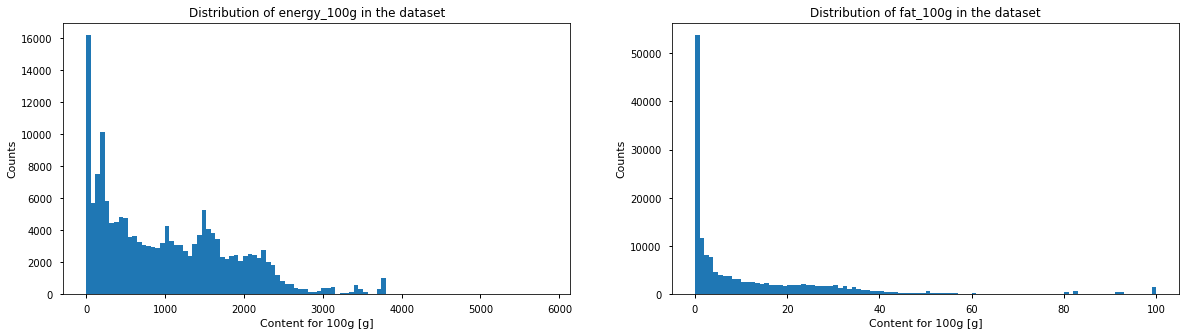

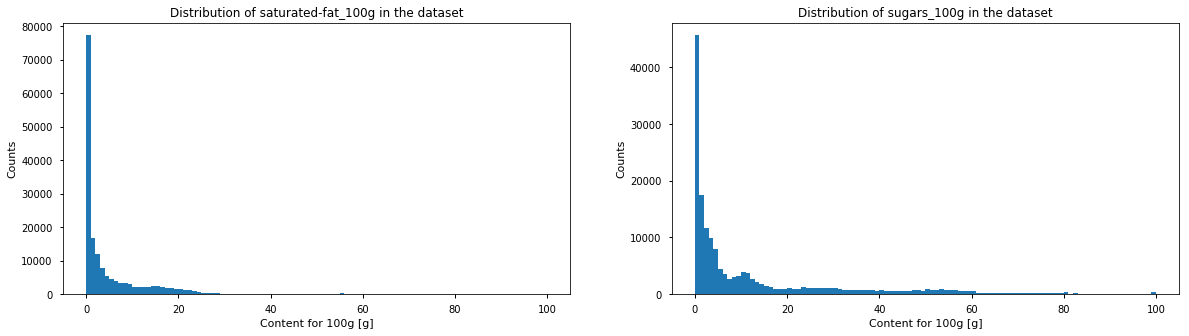

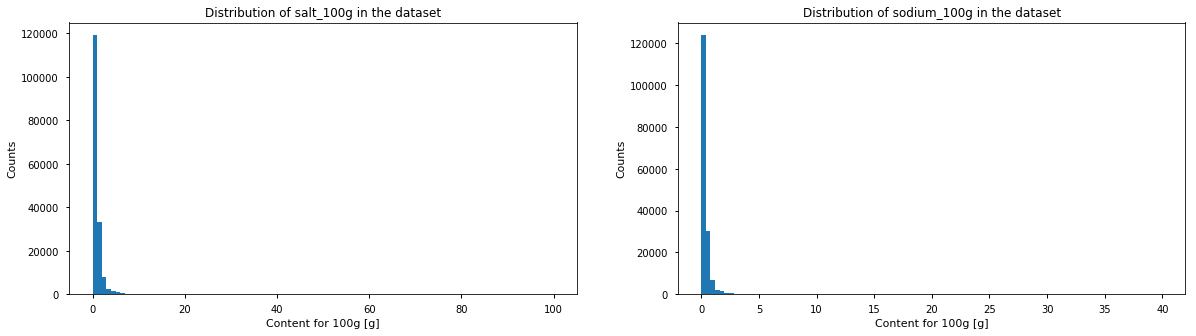

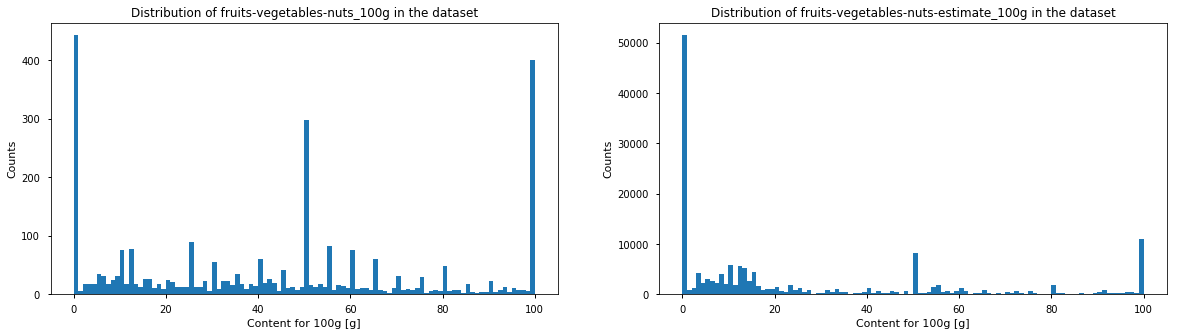

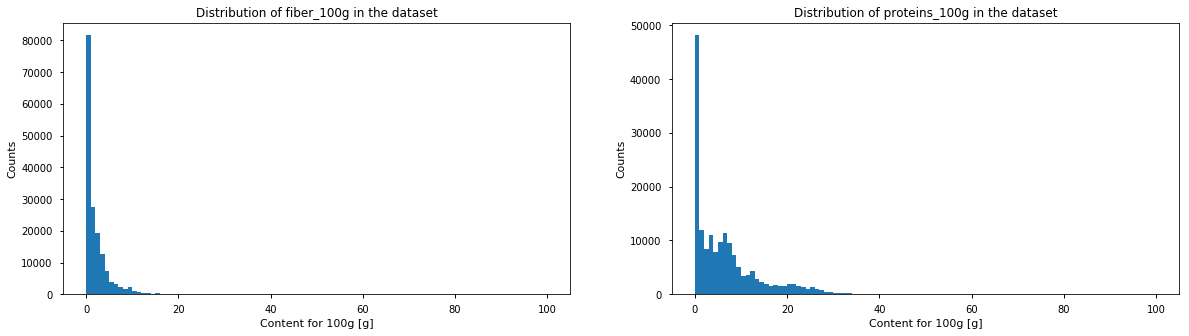

In [29]:
# Plot histograms in serie by iterating over each column
i = 1
for index in range(2, len(data_food_final.columns)):
    
    # Select column data
    column = data_food_final.columns[index]
    
    # Remove nan
    cleaned_column = data_food_final[column][~np.isnan(data_food_final[column])]    

    if i > 2:
        i -= 2
    
    # Create a new subplot row
    if i == 1:
        plt.figure(figsize = (20, 5))
    
    # Plotting column's histogram
    plt.subplot(1, 2, i)
    plt.hist(cleaned_column, bins = 100, histtype = 'stepfilled');
    plt.title('Distribution of {} in the dataset'.format(column));
    plt.ylabel('Counts');
    plt.xlabel('Content for 100g [g]');
    plt.axis('tight');
    
    if i == 2:
        plt.show()
    i += 1

The histogramms of sugar, fat, saturate fat, salt, sodium, fiber and proteins have a very similar aspect. We will see in the following graph if it is correspond to a power law.
    
The energy histogram is a bit more spread in higher values. Both fruit content look very destructured, but it is not surprising as most of these values are estimates. Moreover, the Nutri-Score algorithm make the distinction between large categories : <40%, >40%, >60% and >80%. Therefore, the estimation of fruit content do not have to be precise, but rather to give a more general idea. However, there is no solid convention for the estimation.

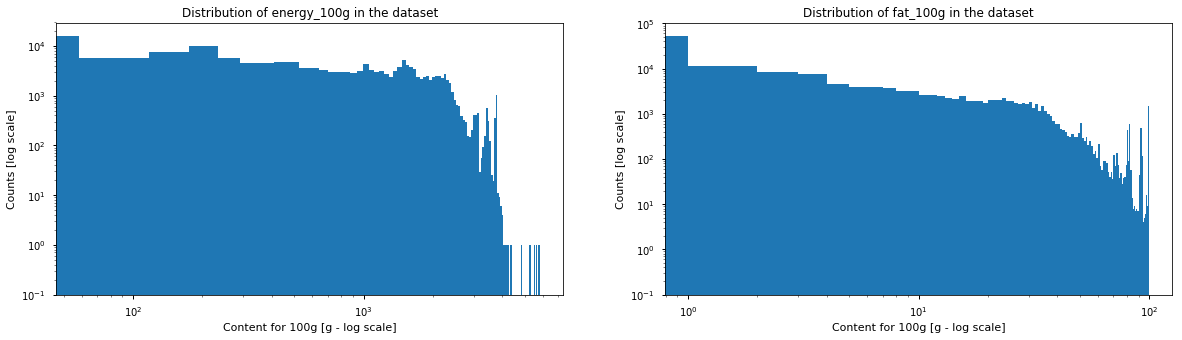

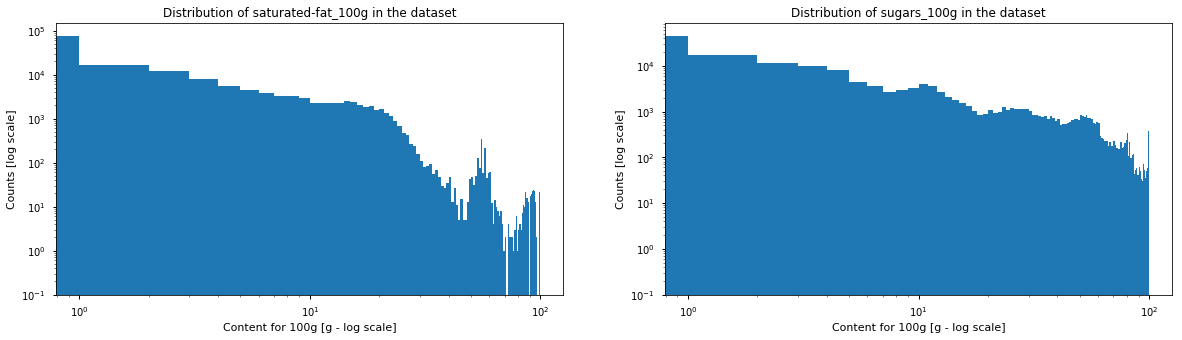

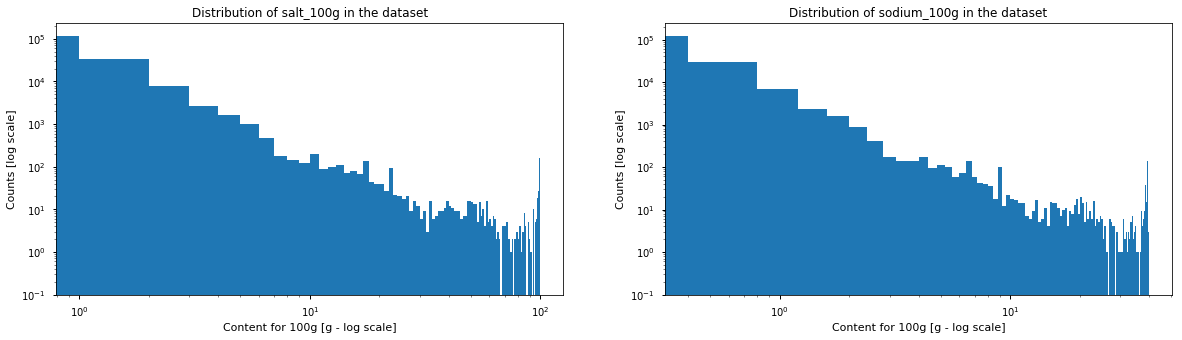

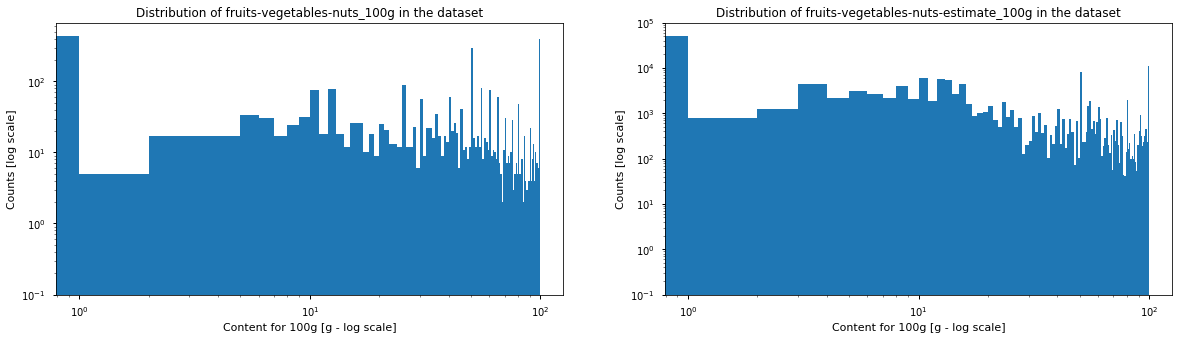

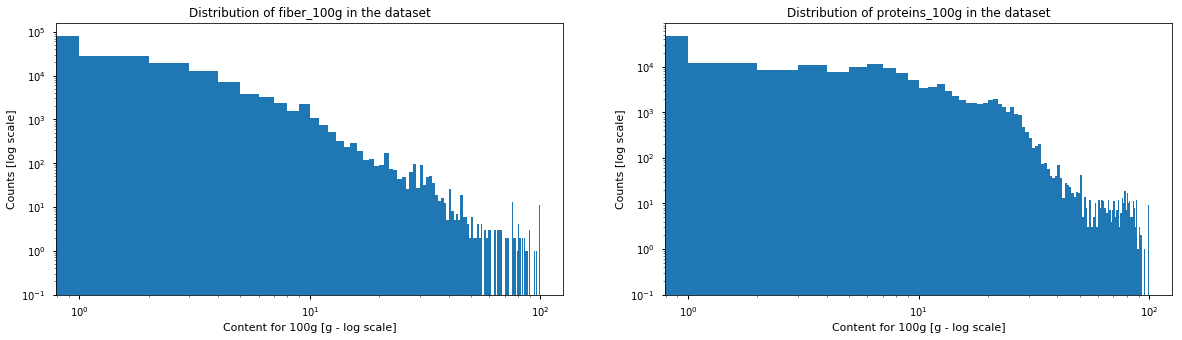

In [30]:
# Plot histograms in serie by iterating over each column
i = 1
for index in range(2, len(data_food_final.columns)):
    
    # Select column data
    column = data_food_final.columns[index]
    
    # Remove nan
    cleaned_column = data_food_final[column][~np.isnan(data_food_final[column])]    

    if i > 2:
        i -= 2
        
    # Create a new subplot row
    if i == 1:
        plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, i)
   
    # Plotting column's histogram
    plt.hist(cleaned_column, bins = 100, histtype = 'stepfilled', log = True);
    plt.title('Distribution of {} in the dataset'.format(column));
    plt.ylabel('Counts [log scale]');
    plt.xlabel('Content for 100g [g - log scale]');
    plt.xscale('log');
    plt.axis('tight');
    if i == 2:
        plt.show()
    i += 1

We see that salt and sodium may represent a power law caracterised by the straight line. Fiber and sugar also have a similar aspect. We observe that proteins, energy, fat and saturated-fat have a horizontal line at the begining and at the end a drop in the counts. 

In [31]:
data_food_final.corr(method ='pearson')

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
energy_100g,1.000000,0.817869,0.626831,0.319871,-0.023507,-0.023510,-0.171717,-0.245808,0.229026,0.271525
fat_100g,0.817869,1.000000,0.733552,-0.033292,-0.003381,-0.003385,-0.166035,-0.200962,0.065585,0.169655
saturated-fat_100g,0.626831,0.733552,1.000000,0.061045,-0.006936,-0.006938,-0.223890,-0.239060,0.027153,0.168513
sugars_100g,0.319871,-0.033292,0.061045,1.000000,-0.077787,-0.077780,0.074202,0.009511,0.047744,-0.194738
salt_100g,-0.023507,-0.003381,-0.006936,-0.077787,1.000000,0.999999,-0.101725,-0.050666,-0.004311,0.063660
sodium_100g,-0.023510,-0.003385,-0.006938,-0.077780,0.999999,1.000000,-0.101723,-0.050664,-0.004314,0.063649
fruits-vegetables-nuts_100g,-0.171717,-0.166035,-0.223890,0.074202,-0.101725,-0.101723,1.000000,0.999981,0.134036,-0.214541
fruits-vegetables-nuts-estimate_100g,-0.245808,-0.200962,-0.239060,0.009511,-0.050666,-0.050664,0.999981,1.000000,0.144027,-0.205393
fiber_100g,0.229026,0.065585,0.027153,0.047744,-0.004311,-0.004314,0.134036,0.144027,1.000000,0.183465
proteins_100g,0.271525,0.169655,0.168513,-0.194738,0.063660,0.063649,-0.214541,-0.205393,0.183465,1.000000


There are many interesting correlations. 

The energy is highly correlated to fat and saturated fat, and moderately to sugar, fiber and proteins. This is a coherent correlation as it is those nutrients which are the source of energy.
Saturated fat is highly correlated to fat as the first is a subcategory of the second.
Sodium and salt are perfectly correlated as the have a fixed ration salt/sodium of 2.5.
Both fruit content, real and estimated, are perfectly correlated due to the cleaning. Estimated fruits content has a moderated negative correlation with energy, fat and saturated fat. But it is interesting that both fruits content and sugar are not correlate even if the fruits-vegetable-nuts content increase sugars content of a product. 

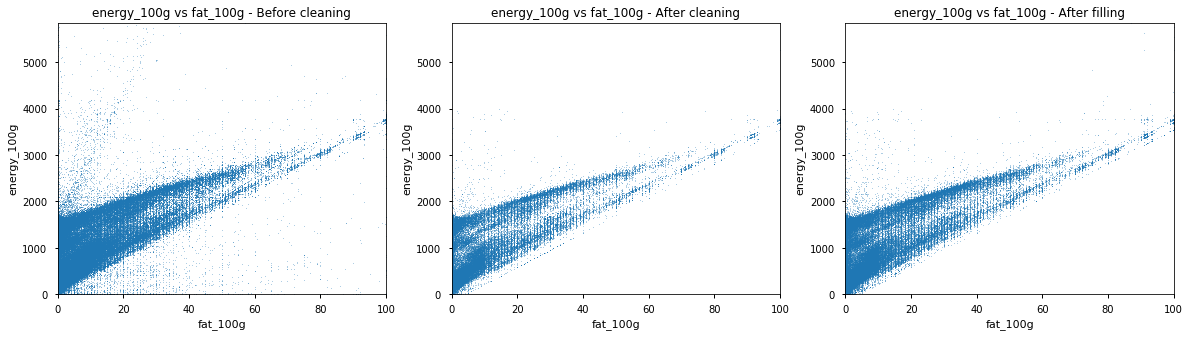

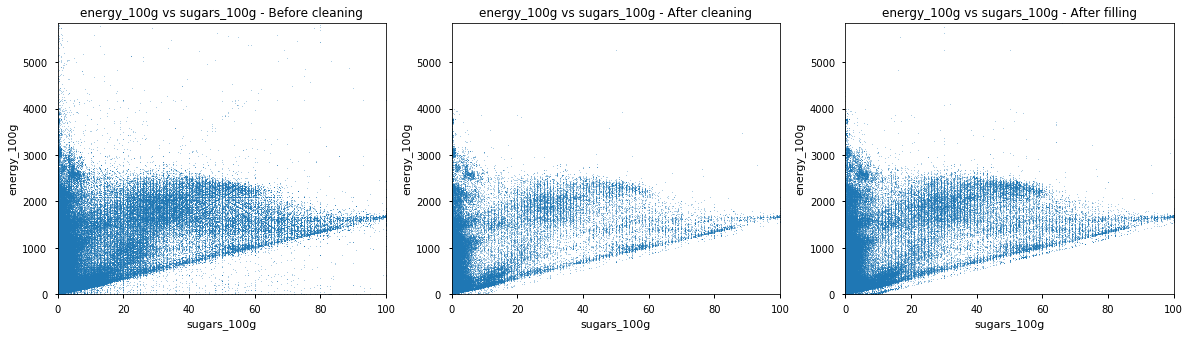

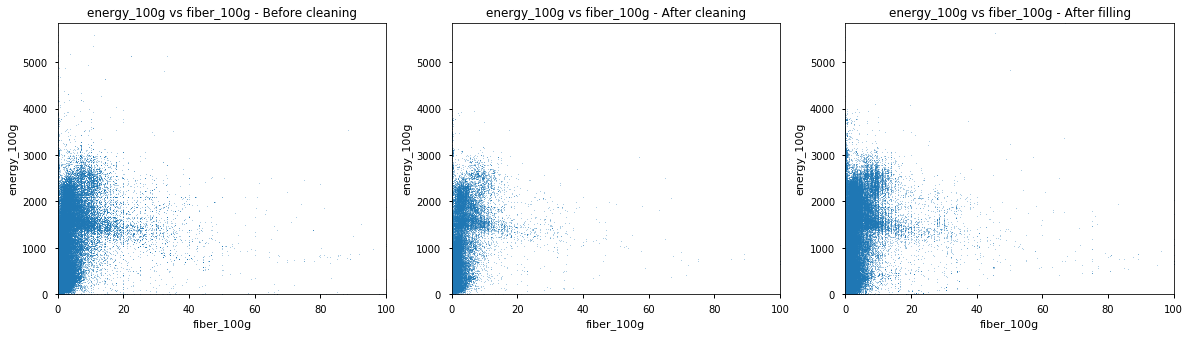

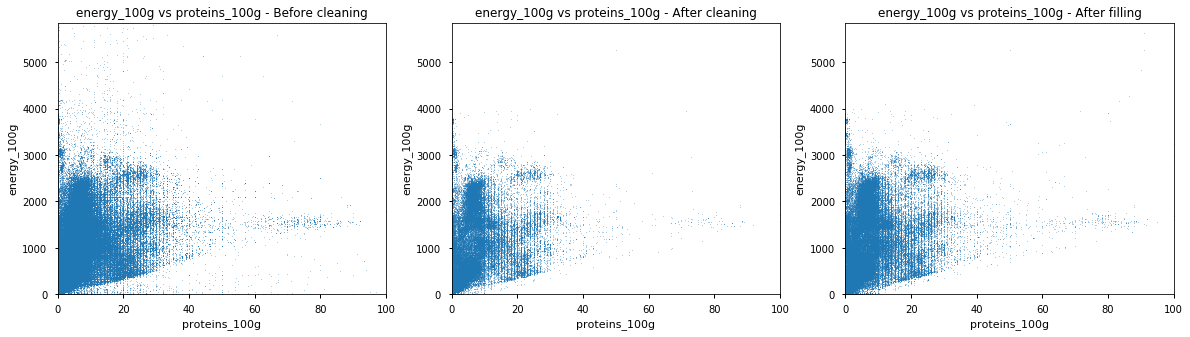

In [32]:
plt_with_energy = [3, 5, 10, 11]

for i_col in range(len(plt_with_energy)):
    x_col = data_food_final.columns[plt_with_energy[i_col]]
    
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(data_raw[x_col],data_raw['energy_100g'], s=0.1);
    plt.title('energy_100g vs {} - Before cleaning'.format(x_col));
    plt.xlabel(x_col);
    plt.ylabel('energy_100g');
    plt.axis([0, 100, 0, 5849]);
    
    plt.subplot(1, 3, 2)
    plt.scatter(data_food[x_col],data_food['energy_100g'], s=0.1);
    plt.title('energy_100g vs {} - After cleaning'.format(x_col));
    plt.xlabel(x_col);
    plt.ylabel('energy_100g');
    plt.axis([0, 100, 0, 5849]);
    

    plt.subplot(1, 3, 3)
    plt.scatter(data_food_final[x_col],data_food_final['energy_100g'], s=0.1);
    plt.title('energy_100g vs {} - After filling'.format(x_col));
    plt.xlabel(x_col);
    plt.ylabel('energy_100g');
    plt.axis([0, 100, 0, 5849]);

    plt.show()
    

We used these scatter plots in order to obtain new insights about the data and get cues about the cleaning possibilites.

The dirty fat-to-energy plot shows a triangular shape. The low side has a slope of 37kJ, which is the energy density of a gram of fat. The triangular shape comes from a spread in low values of fat. This is due to the presence of sugar, proteins and fibers which also contribute to the energy of a product. As the amount of fat increase, it becomes the main source of energy. The cleaning sets a minimum energy amount, based on the other nutrients values, to which we substract a constant, as an error margin.

The other graphs have similar behaviour. The slopes are 17 for sugar and proteins and 8 for fibers.

One can observe that the most important cleaning of the database occurs before its filling. Indeed, the distribution found in the scatter plot is identical if we compare it to the corresponding scatter plot before the automatic filling process.

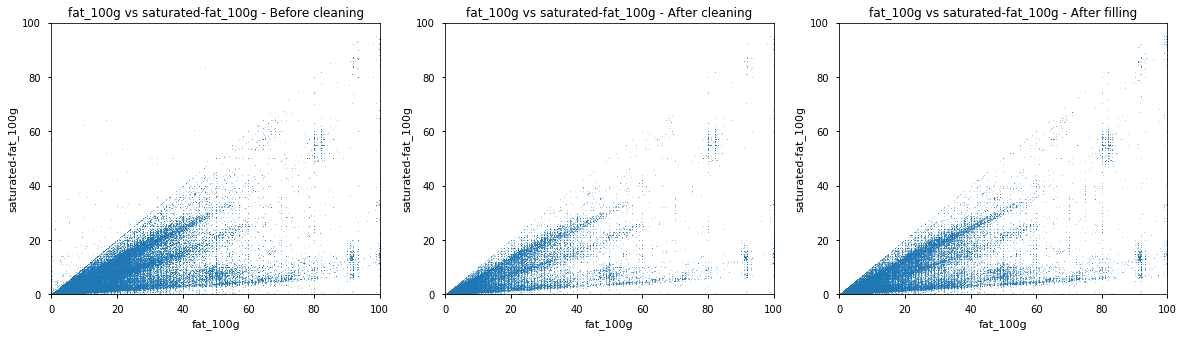

In [33]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(data_raw['fat_100g'],data_raw['saturated-fat_100g'], s=0.1);
plt.title('fat_100g vs saturated-fat_100g - Before cleaning');
plt.xlabel('fat_100g');
plt.ylabel('saturated-fat_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 2)
plt.scatter(data_food['fat_100g'],data_food['saturated-fat_100g'], s=0.1);
plt.title('fat_100g vs saturated-fat_100g - After cleaning');
plt.xlabel('fat_100g');
plt.ylabel('saturated-fat_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 3)
plt.scatter(data_food_final['fat_100g'],data_food_final['saturated-fat_100g'], s=0.1);
plt.title('fat_100g vs saturated-fat_100g - After filling');
plt.xlabel('fat_100g');
plt.ylabel('saturated-fat_100g');
plt.axis([0, 100, 0, 100]);
plt.show()

The dirty scatter plot indicates that some product have a higher value of saturated fat than fat, which is impossible. As the criterion used in Nutri-Score is the amount of saturated fat, we then set for erroneous product the amount of fat up to the amount of saturated fat. This is a conservative way of cleaning as it tends to penalize products.

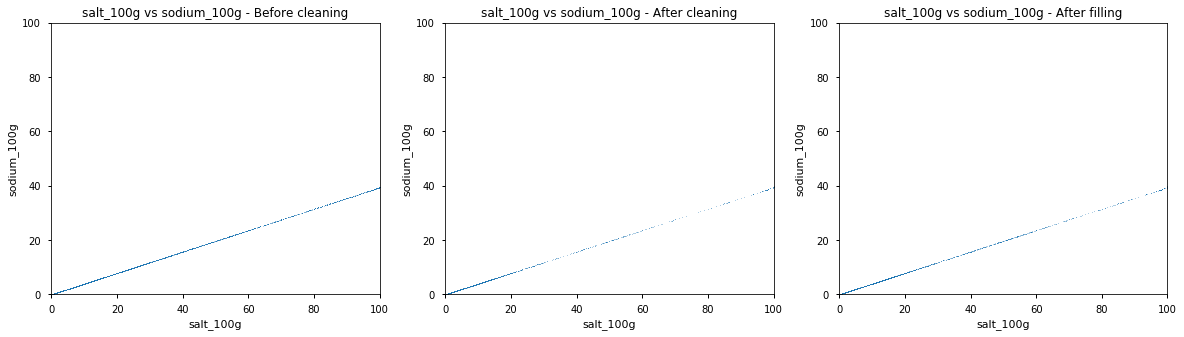

In [34]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(data_raw['salt_100g'],data_raw['sodium_100g'], s=0.1);
plt.title('salt_100g vs sodium_100g - Before cleaning');
plt.xlabel('salt_100g');
plt.ylabel('sodium_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 2)
plt.scatter(data_food['salt_100g'],data_food['sodium_100g'], s=0.1);
plt.title('salt_100g vs sodium_100g - After cleaning');
plt.xlabel('salt_100g');
plt.ylabel('sodium_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 3)
plt.scatter(data_food_final['salt_100g'],data_food_final['sodium_100g'], s=0.1);
plt.title('salt_100g vs sodium_100g - After filling');
plt.xlabel('salt_100g');
plt.ylabel('sodium_100g');
plt.axis([0, 100, 0, 100]);
plt.show()

The slope of the scatter plot is 2.5 as expected. Most of the data is clean, changes are minor.

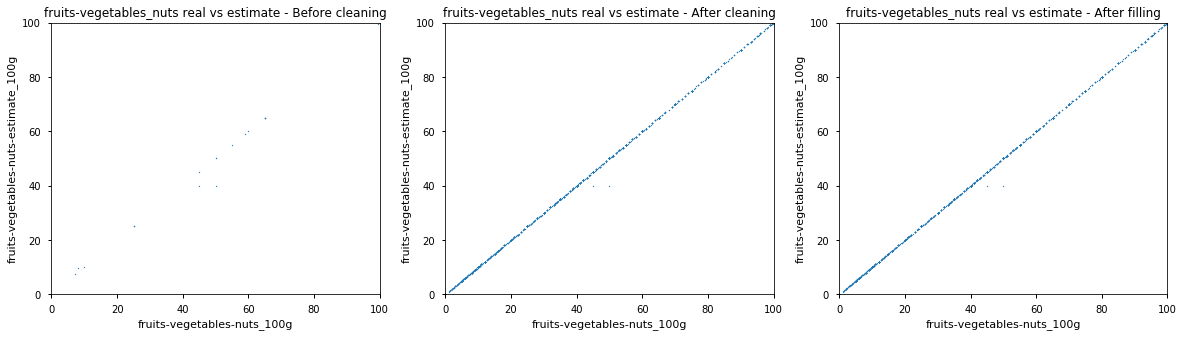

In [35]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(data_raw['fruits-vegetables-nuts_100g'],
            data_raw['fruits-vegetables-nuts-estimate_100g'], s=1);
plt.title('fruits-vegetables_nuts real vs estimate - Before cleaning');
plt.xlabel('fruits-vegetables-nuts_100g');
plt.ylabel('fruits-vegetables-nuts-estimate_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 2)
plt.scatter(data_food_final['fruits-vegetables-nuts_100g'],
            data_food_final['fruits-vegetables-nuts-estimate_100g'], s=1);
plt.title('fruits-vegetables_nuts real vs estimate - After cleaning');
plt.xlabel('fruits-vegetables-nuts_100g');
plt.ylabel('fruits-vegetables-nuts-estimate_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 3)
plt.scatter(data_food_final['fruits-vegetables-nuts_100g'],
            data_food_final['fruits-vegetables-nuts-estimate_100g'], s=1);
plt.title('fruits-vegetables_nuts real vs estimate - After filling');
plt.xlabel('fruits-vegetables-nuts_100g');
plt.ylabel('fruits-vegetables-nuts-estimate_100g');
plt.axis([0, 100, 0, 100]);
plt.show()

This displays mostly the completion during the cleaning part.

In [36]:
# Add the nutriscore data on the completed dataset
data_nutriscore = data_clean[['nutrition-score-fr_100g','nutrition_grade_fr']]

data_food_nutri = pd.merge(data_nutriscore,data_food_final, on = 'code' )

data_food_nutri = data_food_nutri[~data_food_nutri.nutrition_grade_fr.isna()]

# Segregate beverages products and non-beverages products for data analysis in two dataset
data_food_nutri_beverages = data_food_nutri[
    data_food_nutri.categories_tags.str.contains('beverages', case=False) &\
    ~data_food_nutri.categories_tags.str.contains('en:plant-based-foods,', case=False) &\
    ~data_food_nutri.categories_tags.str.contains('milk', case=False)]

data_food_nutri_non_beverages = data_food_nutri[
    ~(data_food_nutri.categories_tags.str.contains('beverages', case=False) &\
      ~data_food_nutri.categories_tags.str.contains('en:plant-based-foods,', case=False) &\
      ~data_food_nutri.categories_tags.str.contains('milk', case=False))]

#### Beverages products analysis

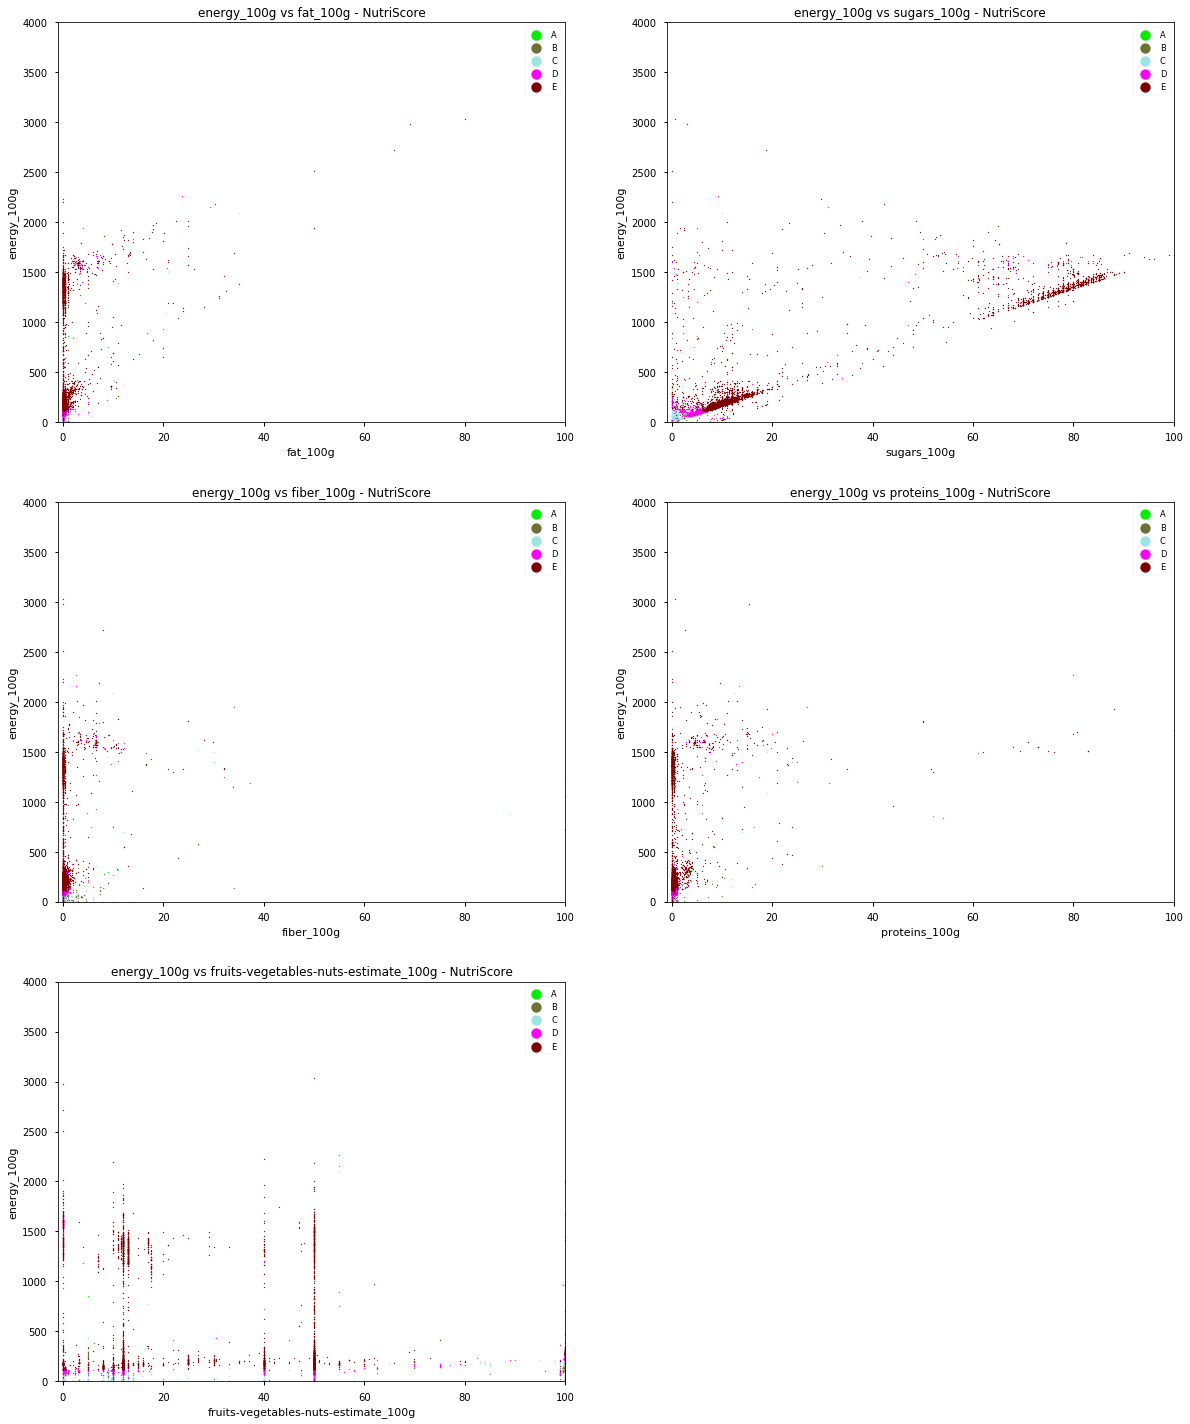

In [37]:
# Create grade-based dataset
data_food_nutri_beverages_A = data_food_nutri_beverages[
    data_food_nutri_beverages['nutrition_grade_fr'] == 'a']
data_food_nutri_beverages_B = data_food_nutri_beverages[
    data_food_nutri_beverages['nutrition_grade_fr'] == 'b']
data_food_nutri_beverages_C = data_food_nutri_beverages[
    data_food_nutri_beverages['nutrition_grade_fr'] == 'c']
data_food_nutri_beverages_D = data_food_nutri_beverages[
    data_food_nutri_beverages['nutrition_grade_fr'] == 'd']
data_food_nutri_beverages_E = data_food_nutri_beverages[
    data_food_nutri_beverages['nutrition_grade_fr'] == 'e']

# Color-blind friendly colorscale
Color = ['#00EE00','#707030', '#9BE5E5', '#FF00FF', '#800000']

fig = plt.figure(figsize=(20, 25))
ax = fig.add_subplot(321)
plt.title('energy_100g vs fat_100g - NutriScore');
plt.xlabel('fat_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

# Plot fat amount in function of energy
ax.scatter(data_food_nutri_beverages_A['fat_100g'],
           data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_beverages_B['fat_100g'],
           data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_beverages_C['fat_100g'],
           data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_beverages_D['fat_100g'],
           data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_beverages_E['fat_100g'],
           data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(322)
plt.title('energy_100g vs sugars_100g - NutriScore');
plt.xlabel('sugars_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

# Plot sugar amount in function of energy
ax.scatter(data_food_nutri_beverages_A['sugars_100g'],
           data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_beverages_B['sugars_100g'],
           data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_beverages_C['sugars_100g'],
           data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_beverages_D['sugars_100g'],
           data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_beverages_E['sugars_100g'],
           data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(323)
plt.title('energy_100g vs fiber_100g - NutriScore');
plt.xlabel('fiber_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

# Plot fiber amount in function of energy
ax.scatter(data_food_nutri_beverages_A['fiber_100g'],
           data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_beverages_B['fiber_100g'],
           data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_beverages_C['fiber_100g'],
           data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_beverages_D['fiber_100g'],
           data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_beverages_E['fiber_100g'],
           data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(324)
plt.title('energy_100g vs proteins_100g - NutriScore');
plt.xlabel('proteins_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

# Plot protein amount in function of energy
ax.scatter(data_food_nutri_beverages_A['proteins_100g'],
           data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_beverages_B['proteins_100g'],
           data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_beverages_C['proteins_100g'],
           data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_beverages_D['proteins_100g'],
           data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_beverages_E['proteins_100g'],
           data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(325)
plt.title('energy_100g vs fruits-vegetables-nuts-estimate_100g - NutriScore');
plt.xlabel('fruits-vegetables-nuts-estimate_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

# Plot fruit/veg/nuts amount in function of energy
ax.scatter(data_food_nutri_beverages_A['fruits-vegetables-nuts-estimate_100g'],
           data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_beverages_B['fruits-vegetables-nuts-estimate_100g'],
           data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_beverages_C['fruits-vegetables-nuts-estimate_100g'],
           data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_beverages_D['fruits-vegetables-nuts-estimate_100g'],
           data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_beverages_E['fruits-vegetables-nuts-estimate_100g'],
           data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);


Here we do scatter plot for product that we will concider as beverages for our Nutri-Score algorithm. One can observe that most of beverages have low-level of fats but are more sparse concerning sugars and proteins. One can see that the product graded E (worst grade) have a the largest value in terms of energy, sugars and proteins and frequently have less than 50% of fruits/vegetables/nuts. The differences between the other grades (A, B, C & D) are less noticeable. If we had to do separate them using machine learning techniques, it would have been difficult. This is why we preferred to directly develop a calculation algorithm based on the official nutri-score calculation methods.

#### Non-beverages products analysis

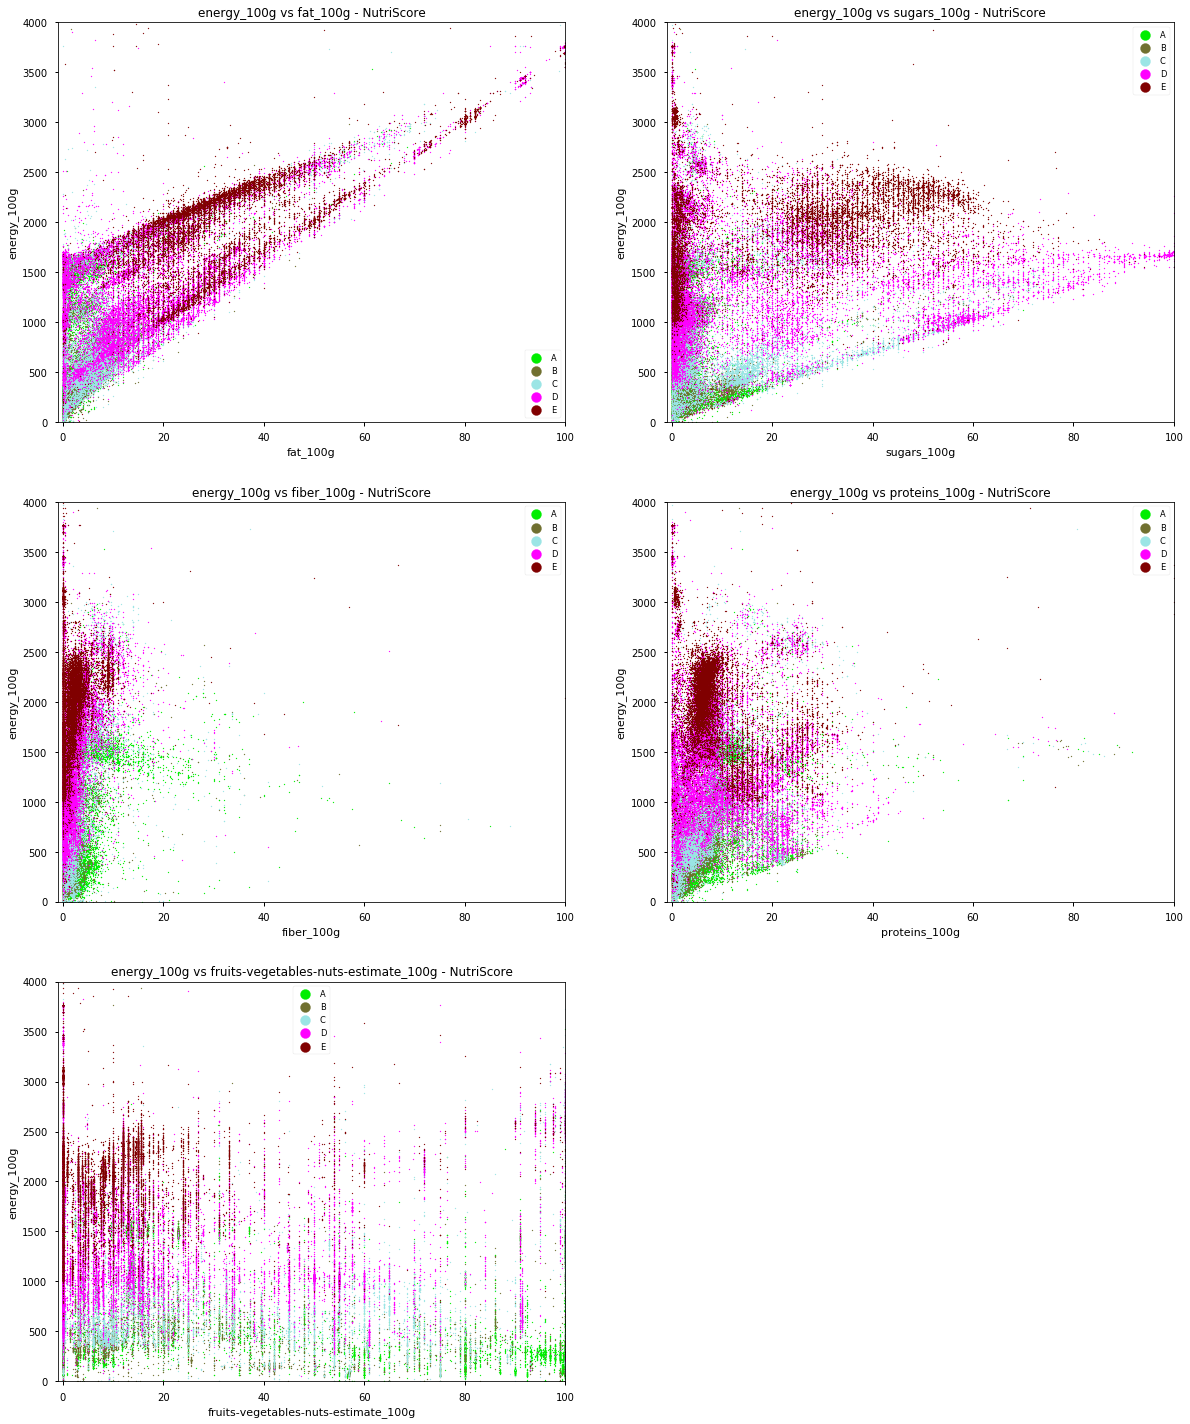

In [38]:
# Create grade-based dataset
data_food_nutri_non_beverages_A = data_food_nutri_non_beverages[
    data_food_nutri_non_beverages['nutrition_grade_fr'] == 'a']
data_food_nutri_non_beverages_B = data_food_nutri_non_beverages[
    data_food_nutri_non_beverages['nutrition_grade_fr'] == 'b']
data_food_nutri_non_beverages_C = data_food_nutri_non_beverages[
    data_food_nutri_non_beverages['nutrition_grade_fr'] == 'c']
data_food_nutri_non_beverages_D = data_food_nutri_non_beverages[
    data_food_nutri_non_beverages['nutrition_grade_fr'] == 'd']
data_food_nutri_non_beverages_E = data_food_nutri_non_beverages[
    data_food_nutri_non_beverages['nutrition_grade_fr'] == 'e']

fig = plt.figure(figsize=(20, 25))
ax = fig.add_subplot(321)
plt.title('energy_100g vs fat_100g - NutriScore');
plt.xlabel('fat_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

# Plot fat amount in function of energy
ax.scatter(data_food_nutri_non_beverages_A['fat_100g'],
           data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['fat_100g'],
           data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['fat_100g'],
           data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['fat_100g'],
           data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['fat_100g'],
           data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(322)
plt.title('energy_100g vs sugars_100g - NutriScore');
plt.xlabel('sugars_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

# Plot sugar amount in function of energy
ax.scatter(data_food_nutri_non_beverages_A['sugars_100g'],
           data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['sugars_100g'],
           data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['sugars_100g'],
           data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['sugars_100g'],
           data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['sugars_100g'],
           data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(323)
plt.title('energy_100g vs fiber_100g - NutriScore');
plt.xlabel('fiber_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

# Plot fiber amount in function of energy
ax.scatter(data_food_nutri_non_beverages_A['fiber_100g'],
           data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['fiber_100g'],
           data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['fiber_100g'],
           data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['fiber_100g'],
           data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['fiber_100g'],
           data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(324)
plt.title('energy_100g vs proteins_100g - NutriScore');
plt.xlabel('proteins_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

# Plot protein amount in function of energy
ax.scatter(data_food_nutri_non_beverages_A['proteins_100g'],
           data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['proteins_100g'],
           data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['proteins_100g'],
           data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['proteins_100g'],
           data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['proteins_100g'],
           data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(325)
plt.title('energy_100g vs fruits-vegetables-nuts-estimate_100g - NutriScore');
plt.xlabel('fruits-vegetables-nuts-estimate_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

# Plot fruit/veg/nuts amount in function of energy
ax.scatter(data_food_nutri_non_beverages_A['fruits-vegetables-nuts-estimate_100g'],
           data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['fruits-vegetables-nuts-estimate_100g'],
           data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['fruits-vegetables-nuts-estimate_100g'],
           data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['fruits-vegetables-nuts-estimate_100g'],
           data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['fruits-vegetables-nuts-estimate_100g'],
           data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

One can observe that the products graded C/D/E have very similar properties. They show a large scale of values for what concerns fats and sugars. But one should note, looking at the fruits/veg/nut content vs energy plot, that it is possible to differentiate the grades according to their energy content, as one can observe several layers. Grade A have a larger amount of fiber, which seems to make sense, as fiber give negative points for the Nutri-Score (NB : the lower the nutriscore, the better the grade).

### NutriScore - Computation

As stated above, we developped our nutri-score computing algorithm using the exact criteria specified in the documents from the french ministry of Agriculture. As we also know the true grade, which is indicated in the database, we can quantify the accuracy of the algorithm and try to increase its efficiency.

In general, except for exeptions, the score are calculate in this manner : 
$$ ScoreBeverages =  Energy + Sugar - Fruits$$
$$ ScoreNonBeverages = NegativePoints - PositivePoints = (Energy + Fat + Sugar + Sodium) - (Fruits + Fibers + Proteins)$$

For beverages grades:
$$ Water ==>  A$$
$$ ScoreBeverages <= 1 ==> B$$
$$ 1 < ScoreBeverages <= 5 ==> C$$
$$ 5 < ScoreBeverages <= 9 ==> D$$
$$ 9 < ScoreBeverages <= 20 ==> E$$

For non-beverages grades:
$$ ScoreNonBeverages < 0 ==> A$$
$$ 0 < ScoreNonBeverages <= 2 ==> B$$
$$ 2 < ScoreNonBeverages <= 10 ==> C$$
$$ 10 < ScoreNonBeverages <= 18 ==> D$$
$$ 18 < ScoreNonBeverages <= 40 ==> E$$

In [53]:
print('{:.2f} % of the products in the cleaned database have NutriScore indication provided by OpenFoodFacts'.\
     format(len(data_food_nutri) * 100 / len(data_food_final)))

48.77 % of the products in the cleaned database have NutriScore indication provided by OpenFoodFacts


In [40]:
# Create new columns to fill in the computed grade and score
data_food_nutri['Predicted_NutriScore_grade'] = np.nan
data_food_nutri['Predicted_NutriScore_score'] = np.nan

# For each product, compute the nutri-score prediction using the algorithm
for index in range(len(data_food_nutri)):

    product = data_food_nutri.iloc[[index]]
    nutriscore, final_score = computeNutriScore(product)
    
    # Complete the dataset with the computed values
    data_food_nutri.loc[product.index[0], 'Predicted_NutriScore_grade'] = nutriscore
    data_food_nutri.loc[product.index[0], 'Predicted_NutriScore_score'] = final_score

In [41]:
# Load the true nutriscore grade (according to openfoodfacts) and the computed grade
y_true = data_food_nutri['nutrition_grade_fr']
y_pred = data_food_nutri['Predicted_NutriScore_grade']
labels = ['a', 'b', 'c', 'd', 'e', 'Error']

# Compute confusion matrix in order to compare them
confusion_matrix_ = confusion_matrix(y_true, y_pred, labels = labels)
pd.DataFrame(confusion_matrix(y_true, y_pred, labels= labels), index = labels, columns = labels)

,a,b,c,d,e,Error
a,11322,564,59,5,8,35
b,1772,9311,438,35,24,113
c,596,1660,14391,479,87,126
d,109,170,3682,19692,234,218
e,5,27,554,1734,14591,125
Error,0,0,0,0,0,0


The columns indicate the predicted grade and the rows the true grade.

In [42]:
# Again, we segregate beverages and non-beverages products in order to analyse them separately
data_food_nutri_beverages = data_food_nutri[
    data_food_nutri.categories_tags.str.contains('beverages', case=False) &\
    ~data_food_nutri.categories_tags.str.contains('en:plant-based-foods,', case=False) &\
    ~data_food_nutri.categories_tags.str.contains('milk', case=False)]

data_food_nutri_non_beverages = data_food_nutri[
    ~(data_food_nutri.categories_tags.str.contains('beverages', case=False) &\
      ~data_food_nutri.categories_tags.str.contains('en:plant-based-foods,', case=False) &\
      ~data_food_nutri.categories_tags.str.contains('milk', case=False))]

In [43]:
# Compute the percentage of correct prediction, according to the grade
print("For Beverages :\n")
ratio_grade = len(data_food_nutri_beverages[
    data_food_nutri_beverages['nutrition_grade_fr'] == data_food_nutri_beverages[
        'Predicted_NutriScore_grade']]) * 100 / len(data_food_nutri_beverages)

# Compute the percentage of correct prediction, according to the score
ratio_score = len(data_food_nutri_beverages[
    data_food_nutri_beverages['nutrition-score-fr_100g'] == data_food_nutri_beverages[
        'Predicted_NutriScore_score']]) * 100 / len(data_food_nutri_beverages)

print('The accuracy according to the grade is {:.2f} %, the accuracy according to the score is {:.2f} %.\n'.\
          format(ratio_grade,ratio_score))

For Beverages :

The accuracy according to the grade is 89.38 %, the accuracy according to the score is 59.42 %.



The fact that the score accuracy is so much lower than the grade accuracy might be explained by the way our algorithm compute the grade for water. Only mineral waters can have the grade A, so our algorithm is focused on the tags and not on the score computation.

In [44]:
# Compute the percentage of correct prediction, according to the grade
print("For non-Beverages :\n")
ratio_grade = len(data_food_nutri_non_beverages[
    data_food_nutri_non_beverages['nutrition_grade_fr'] == data_food_nutri_non_beverages[
        'Predicted_NutriScore_grade']]) * 100 / len(data_food_nutri_non_beverages)

# Compute the percentage of correct prediction, according to the score
ratio_score = len(data_food_nutri_non_beverages[
    data_food_nutri_non_beverages['nutrition-score-fr_100g'] == data_food_nutri_non_beverages[
        'Predicted_NutriScore_score']]) * 100 / len(data_food_nutri_non_beverages)

print('The accuracy according to the grade is {:.2f} %, the accuracy according to the score is {:.2f} %.\n'.\
          format(ratio_grade,ratio_score))

For non-Beverages :

The accuracy according to the grade is 83.79 %, the accuracy according to the score is 60.14 %.



One can note the very high accuracy for beverages and non-beverages according to the grade. The algorithm raises low amount of errors that are due to missing values. Moreover, we can estimate that some information entered in the database are still inaccurate, even if we tried to complete and to correct it.

We also discovered some absurdities in the calculation of nutriscore by openfoodfacts. For example, for chocolate milk drink powders, the rating is done as a solid, because chocolate is a powder, but the information on which openfoodfact nutriscore is based is the information of the diluted powder. Thus, powdered chocolate has the double advantage of being considered as a solid, but of having its diluted values used. This results in an A or B score, which is ridiculous given the nutritional value of chocolate milk drinks.

Also, the fruit-vegetable-nuts estimation is difficult to handle, as there is no completely defined convention. Most of this classification has to be done manually when the product is input in the database.

### Information about food additive and food recommendation

We find two website that provided informations about <a href="https://pages.rts.ch/emissions/abe/1371092-liste-des-principaux-additifs-alimentaires.html">food additive [in French / from RTS Radio Télévision Suisse</a> and about <a href="http://www.sge-ssn.ch/fr/science-et-recherche/denrees-alimentaires-et-nutriments/recommandations-nutritionnelles/valeurs-de-reference-dach/">food recommendation [in French / from SSN Société Suisse de Nutrition</a>. We can use it to give additional informations to our users.

## List of internal milestones up until poster presentation
### User interface design
* Develop an interface, so that the user can enter the aliments he eats into the program
* For missing information, the user must be able to choose either to enter the data himself/herself, or to use the automatic reconstruction of the data by the closest foods at category level, or to use the automatic data query of the US Department of Agriculture
* The interface must allow the user to enter the quantities consumed, for each food
* The interface must optionally allow the user to indicate the period over which he/she has consumed these foods (snacks, meals, days, etc.)

### Algorithm
* Adapt the algorithm to take the quantities into account and to weight them in order to obtain a global indice
* Adapt the algorithm to take into account the nutrients of the expanded Nutri-score
* Adapt the algorithm to determine if the quantity of food ingested during the specified time seems to be reasonable
* Improve the robustness of the algorithm by improving error handling when erroneous or non-numerical values are entered by the user
* Adapt the algorithm to compare the values entered with the nutritional recommandations and identify deficiencies, excesses and lack of diversity
* Adapt the algorithm to be able to retrieve elements with the desired nutritional values, so that it can be suggested to the user

### Information design
* The interface must present the user with the quantities of nutrients he/she has consumed
* The user must receive an indicative assessment of the nutritional quality of his/her food (expanded Nutri-score)
* The program must indicate to the user the main problems of his diet. Warn the user about nutritional deficiencies, excesses and lack of diversity
* The user should receive suggestions for foods that could help to fill nutritional gaps and achieve healthier eating habits

### Collect information for the poster
* Test the program with a volunteer and keep this test as a case study for using the program
* Extract the information, figures and charts necessary for the poster
* Writing the text of the poster

### Creation of the poster and presentation
* Assemble the elements for the poster and print it
* Prepare for the oral presentation
* Present the poster (21/22/23 Jan.)

## Overview of Milestone 3
During this Milestone, we will present different things such as the cleaning part (part 2), and the 2 different algorithm that we create that we use in our app. You will see more informations about our app and our project in general <a href="https://nutriteam.github.io/Nutri_Score/home.html" target= "_blanck">here</a>.

## Cleaning - part 2
With the database that we complete - see Milestone 2 - we have to cleaning and complete a little bit more. Frist of all, we see that some product name as extreme long name so it reduces the readibility for our app. With them, we will keep only the begining of the name before that a common string is detected ([même code...]). For our app again, we decide to add brands. Finally to improve the speed of our algorithm to detect healthier product than the one selected by the users, we compute the grade and the NutriScore for each product of the database.

```python
# set value by default
data_food_final['Predicted_NutriScore_grade'] = np.nan
data_food_final['Predicted_NutriScore_score'] = np.nan
data_food_final['Brands'] = ' '

for index in range(len(data_food_final)):
    if (index % 100==0):
        print(str(index*100/len(data_food_final))[:6],'%')
        
    product = data_food_final.iloc[[index
    
    # Compute NutriScore
    nutriscore, final_score = computeNutriScore(product)
    
    # Complete the dataset with the computed values
    data_food_final.loc[product.index[0], 'Predicted_NutriScore_grade'] = nutriscore
    data_food_final.loc[product.index[0], 'Predicted_NutriScore_score'] = final_score
    
    # Search for common feature for the product name with long name
    regex_group = re.search('(.*)(?=même code)', product.product_name[0])
    
    if regex_group != None:
        data_food_final.loc[product.index[0], 'product_name'] = regex_group.group(0)[:-1]
    
    # add brands                               
    Brands = data_clean.at[product.index[0], 'brands']
    if str(Brands) != 'nan':
        data_food_final.loc[product.index[0], 'Brands'] = Brands
    
    

data_food_final.to_csv('OpenFoodFacts_final.csv')
```

## General NutriScore Algorithm
To give informations about a unique NutriScore for the users, we develop a general NutriScore algorithm. You can see the code for it inside `df_nutri_create.py ` file. 

These are the steps that inside our algorithm
* We take the barcode and the quantity [in g/ml] for each product that the users eat and that inside the databse of Open Food Facts. If the users eats raw product, we take the name of the product and its quantity [in g/ml].
* We create a new dataframe that contains all the product that are in the Open Food Facts database and add a column of quantity.
* If the users eats raw product, we will search by using the API (see Milestone 2) for the product and add it to our new dataframe.
* We put inside real fruits/vegetables/nuts the value that give our first NutriScore algorithm for the fruits contents of each product. It is an essential step because after some steps, we will call our original NutriScore algorithm. This one will search at the begining if a value is inside the real fruits/vegetables/nuts. 
* We multiply each column by the quantity of each product. 
* We separate beverages and non-beverages because it is not the same calculation for each case. We decide also to give a NutriScore grade for beverages and non-bevearages case to our user. It will improve by this way the informations. The users can know where he/she has to improve its diatry. 
* For beverages, we separate water to non-pure water. Pure water has automaticaly a A grade. The other beverages cannot have A as grade. 
* Du to our original NutriScore algorithm, we have to take care of some exeptions for the non-beverages. Some product must have 0 as protein. 
* We sum the dataframe and divide by the sum of quantity. We put the proportion of each column of this 'big product' for 100g. 
* We call our orginal NutriScore algorithm to compute the score and the grade.

During the process, we exctract also important informations that we can use to give recomendations to our user. 

In [2]:
data_food_final = pd.read_csv(DATA_FOLDER + 'OpenFoodFacts_final.csv', index_col  = [0], low_memory = False)

In [3]:
list_product = []
number_of_product = 1000

for index in range(number_of_product):
    list_product.append((data_food_final.iloc[[randint(0, len(data_food_final))]].index[0], randint(1, 200)))

Dict_ = nutri.main_nutri(list_product, data_food_final, [])

if Dict_['Score_Beverages'] != None:
    print('The grade for your beverages is {} for a score of {}'\
          .format(Dict_['NutriScore_Beverages'].upper(), Dict_['Score_Beverages']))
    
if Dict_['Score_Non_Beverages'] != None:
    print('The grade for your non-beverages is {} for a score of {}'\
          .format(Dict_['NutriScore_Non_Beverages'].upper(), Dict_['Score_Non_Beverages']))
    
print('You drink {:.3f} ml'.format(Dict_['Beverages_quantites']))
print('You drink {:.3f} % of non pure-water (eg. sodas)'.format(Dict_['Soda_ratio']))
print('You eat {:.3f} g of fiber'.format(Dict_['Fiber']))
print('You eat {:.3f} % of fruits, vegetables and/or nuts'.format(Dict_['Fruits']))
print('You eat {:.3f} mg of sodium'.format(Dict_['Sodium']*1000))
print('You eat {:.3f} g of protein'.format(Dict_['Protein']))
print('Your energy amount is {:.3f} kJ'.format(Dict_['Energy']))
print('You eat {:.3f} g of sugar'.format(Dict_['Sugar']))
print('You eat {:.3f} g of fat'.format(Dict_['Fat']))

The grade for your beverages is A for a score of 14
The grade for your non-beverages is C for a score of 7
You drink 12672.000 ml
You drink 96.496 % of non pure-water (eg. sodas)
You eat 2213.219 g of fiber
You eat 22.797 % of fruits, vegetables and/or nuts
You eat 441991.405 mg of sodium
You eat 7348.369 g of protein
Your energy amount is 1072746.976 kJ
You eat 13472.354 g of sugar
You eat 13295.796 g of fat


To improve the readibility of the software, the feedback will be delivered by email to the user. In order to do that, the values entered by the user are compared with the recommendations of the SSN (Swiss Society of Nutrition, see Milestone 2). A function automatically creates the text for the email and another send the email to the user.

In [99]:
text = Rec_text(True, 22, 1.6, 1, 75, Dict_)
Send_rec('EMAIL@EMAIL.EMAIL', text)

## Healthier product
Finally, to improve the diet of our user, an algorithm was developped in order to offer products with a better score than the ones actually consumed. To this extend, the score and grade of each product contained in the database were computed beforehand. This results is a very small pressure on the memory (only 30 Mb) but in great improvement in terms of computation time, which is a good compromise and allows a higher reactivity.

Based on the dataset, our algorithm is searching for healthier products, as alternatives to propose to the user. The idea is to allow the user to eat healthier products without imposing foods that he/she do not like. For example, if the user likes to eat cookies, we will not adopt a moralizing tone and advise him to eat fewer cookies. Instead, we're going to offer him another kind of cookie, much healthier. This strategy would in our opinion be much more productive because it adapts to the person's habits, rather than trying to change their eating habits. And as we will see, you can eat much better while eating the same type of food.

The algorithm which provides this recommandation is based on one of the most specific tags of the product selected by the user. It then searches all products that have the same tag and looks at their respective scores. The algorithm will then select the product with the better NutriScore and returns it. If it does not find any similar product with a better NutriScore, the selected product is considered as the healthiest product in its category.

In [6]:
dic_tag = list_df_tags(data_food_final)

In [7]:
for product in list_product[:5]:
    replaced, best_product, best_sc, best_code, old_sc, old_gr, new_gr =\
    find_healthier_product(product, data_food_final, dic_tag)
    
    if replaced & (str(best_product[0]) != 'nan') & (str(best_product[-1]) != 'nan'):
        print('''We suggest to you to replace the product "{}" by this other product https://world.openfoodfacts.org/product/{} {} that has a better Nutri-Score. Your product has a grade of {} and the one that we suggest to you has a grade of {}.\n'''\
            .format(data_food_final.loc[product[0]][0], best_code, str(best_product[0]) + ' (' + str(best_product[-1]) + ')',\
            old_gr, new_gr))
    else:
        print('''Your product "{}" is the best in its category.'''.format(data_food_final.loc[product[0]][0]))

We suggest to you to replace the product "Fanta Mango Geschmack" by this other product https://world.openfoodfacts.org/product/0042111558865 coca cola zéro (coca cola) that has a better Nutri-Score. Your product has a grade of E and the one that we suggest to you has a grade of B.

We suggest to you to replace the product "Crackers integrales" by this other product https://world.openfoodfacts.org/product/4010355117472 Dinkel Waffeln Natur (Dm bio) that has a better Nutri-Score. Your product has a grade of C and the one that we suggest to you has a grade of A.

We suggest to you to replace the product "Poulet riz basmati sauce lait de coco et curry" by this other product https://world.openfoodfacts.org/product/00989688 Chicken Saaq Masala (Marks & Spencer) that has a better Nutri-Score. Your product has a grade of B and the one that we suggest to you has a grade of A.

We suggest to you to replace the product "Queso Crema Philadelphia Chipotle" by this other product https://world.openfo

We did the same thing as before for the recommendations.

In [8]:
text = Better_product_rec(list_product[:5], data_food_final)
Send_rec('EMAIL@EMAIL.EMAIL', text)

## Main structure
We created a general function `algo` that is in charge of calling other functions.

In [11]:
dict_product = {
'Product' : list_product[1:5],
'API' : [('Cookies', 40), ('Banana', 100)],
}

dict_settings = {
'Rec' : True,
'Day' : 1,
'Name' : 'Nutri',
'Surname' : 'Team',
'Email' : 'nutriteamada@gmail.com',
'Age' : 23,
'Sex' : True,
'Pal' : 1.6,
'Weight' : 59,
}

text = algo(dict_product, dict_settings, data_food_final)

## App

To run this programm, an app that runs on Windows was created. You will see more information by reading our Data Story

## Visualization
First of all, we will see the proportion of each grades after computation of the grade for each product.

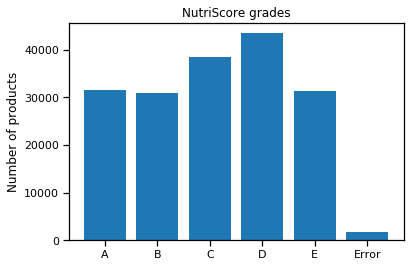

In [12]:
nutri_grade = dict(Counter(list(data_food_final['Predicted_NutriScore_grade'])).most_common())
label = ['A', 'B', 'C', 'D', 'E', 'Error']
values = [nutri_grade['a'], nutri_grade['b'], nutri_grade['c'], nutri_grade['d'], nutri_grade['e'], nutri_grade['Error']]

plt.bar(x=label, height=values);
plt.title('NutriScore grades');
plt.ylabel('Number of products');

We see that the proportion of error is low. Indeed most of the columns are complete so we have less errors. The grades are almost a uniform distribution with a pick on D grade.

To visualize healthier product, we will compute for each tag the minimum score and at the same time, the maximum one. With that, we can compute for each product the differences between its score and the minimum.

In [13]:
list_tags = [key for key,value in dic_tag.items() if value >= 10]
value_min = []
value_max = []
diff_score = []

for tag in list_tags:
    data_ = data_food_final[data_food_final.categories_tags.str.contains(tag, case = False) &\
                            (data_food_final['Predicted_NutriScore_grade'] != 'Error')]
    min_ = min(data_['Predicted_NutriScore_score'].values)
    max_ = max(data_['Predicted_NutriScore_score'].values)
    value_min.append(min_)
    value_max.append(max_)
    
    diff = [score - min_ for score in data_['Predicted_NutriScore_score'].values]
    diff_score.extend(diff)

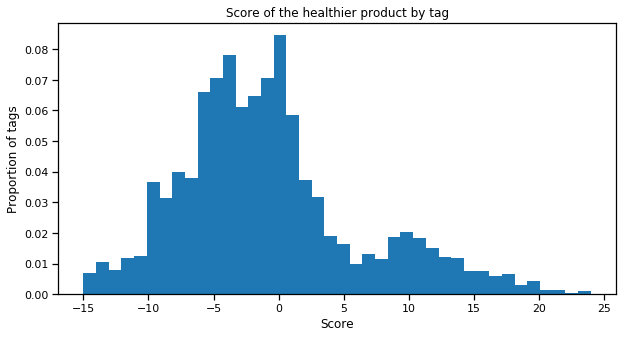

In [14]:
plt.figure(figsize = (10, 5))
plt.hist(value_min, bins=40, density= True);
plt.title('Score of the healthier product by tag');
plt.xlabel('Score');
plt.ylabel('Proportion of tags');

As we can observe, we have a large distribution of the minimum score. Most of healthier products are really healthy (negative score). But we can observe that some healthier product has a quite big score (>20). 

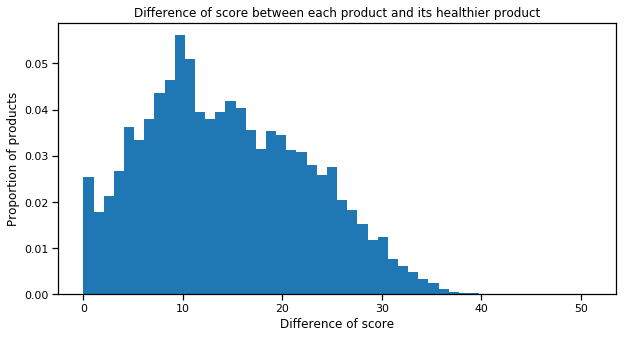

In [15]:
plt.figure(figsize = (10, 5))
plt.hist(diff_score, bins=50, density=True);
plt.title('Difference of score between each product and its healthier product');
plt.xlabel('Difference of score');
plt.ylabel('Proportion of products');

First of all, we see that 2% of the products are the better ones. Indeed, they are represented by the bins at 0. 
The biggest difference is 52. So we have also a large palette of differences but they are concise around 10. 

Scatter between max and min score for each tag


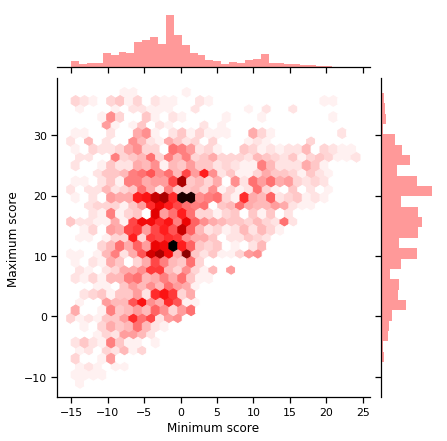

In [16]:
print('Scatter between max and min score for each tag')
gr = (sns.jointplot(x=value_min, y=value_max, kind="hex", color="r").set_axis_labels("Minimum score", "Maximum score"));

In [17]:
diff = [value_max[index] - value_min[index] for index in range(len(value_max))]

up_50 = [(tuple_[0], tuple_[1]) for tuple_ in list(zip(list_tags, diff)) if tuple_[1] >=50]
up_50

[('en:plant-based-foods-and-beverages', 51.0),
 ('en:plant-based-foods', 51.0),
 ('en:groceries', 50.0)]

With this scatter plot, wich represent the distribution for each tag between its highest score and its lowest one. The line is expected because we cannot have a maximum less than the minimum. But we observe that we have a large distribution of maximum. We understand also base on this graph that the highest difference seen on the previous graph is the point on the upper left. We can detect that these big difference are for the tags, 'en:plant-based-foods-and-beverages' and 'en:plant-based-foods'. These tags are the most popular one and are express in the majority of the product. So it represent the biggest difference of score for the whole database.

We see also with the dark points wich represent a larger number of points situated there, that most of the tags have a minimum score around 0 and an maximum around 10, 20. So it is consistent with the previous graph.

## Visit our website https://nutriteam.github.io/Nutri_Score/home.html